In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import seaborn as sns
from counterfactual_package.counterfactual_package.utils.utils import load_json_file, get_model, search_models

### One sample distribution

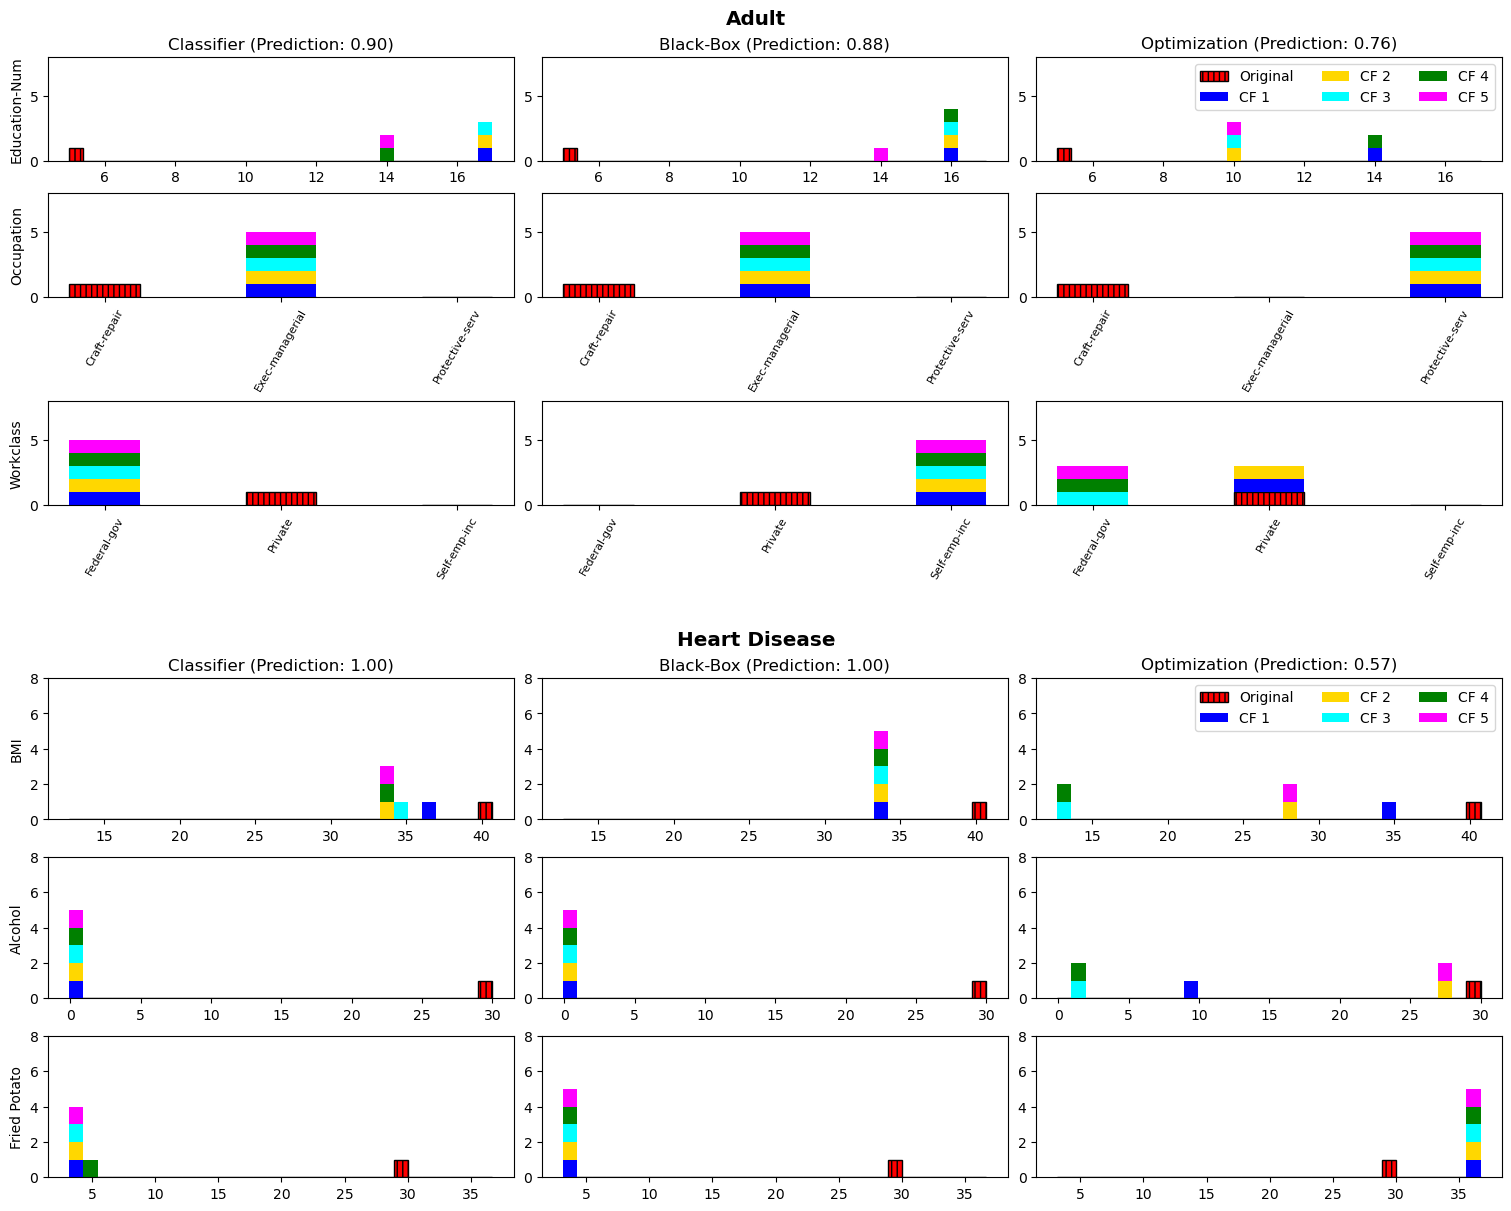

In [29]:
# LOAD DATA
with open("results2plot/one_sample_dist/adult_samples.pkl", "rb") as file:
    adult_samples = pickle.load(file)

with open("results2plot/one_sample_dist/adult_clas_counterfactuals.pkl", "rb") as file:
    adult_clas_counterfactuals = pickle.load(file)
        
with open("results2plot/one_sample_dist/adult_black_box_counterfactuals.pkl", "rb") as file:
    adult_black_box_counterfactuals = pickle.load(file)
        
with open("results2plot/one_sample_dist/adult_optim_counterfactuals.pkl", "rb") as file:
    adult_optim_counterfactuals = pickle.load(file)
        
with open("results2plot/one_sample_dist/heart_disease_samples.pkl", "rb") as file:
    heart_disease_samples = pickle.load(file)
        
with open("results2plot/one_sample_dist/heart_disease_clas_counterfactuals.pkl", "rb") as file:
    heart_disease_clas_counterfactuals = pickle.load(file)
        
with open("results2plot/one_sample_dist/heart_disease_black_box_counterfactuals.pkl", "rb") as file:
    heart_disease_black_box_counterfactuals = pickle.load(file)

with open("results2plot/one_sample_dist/heart_disease_optim_counterfactuals.pkl", "rb") as file:
    heart_disease_optim_counterfactuals = pickle.load(file)


with open("results2plot/one_sample_dist/adult_clas_prediction.pkl", "rb") as file:
    adult_clas_prediction = pickle.load(file)

with open("results2plot/one_sample_dist/adult_black_box_prediction.pkl", "rb") as file:
    adult_black_box_prediction = pickle.load(file)

with open("results2plot/one_sample_dist/adult_optim_prediction.pkl", "rb") as file:
    adult_optim_prediction = pickle.load(file)

with open("results2plot/one_sample_dist/heart_disease_clas_prediction.pkl", "rb") as file:
    heart_disease_clas_prediction = pickle.load(file)

with open("results2plot/one_sample_dist/heart_disease_black_box_prediction.pkl", "rb") as file:
    heart_disease_black_box_prediction = pickle.load(file)

with open("results2plot/one_sample_dist/heart_disease_optim_prediction.pkl", "rb") as file:
    heart_disease_optim_prediction = pickle.load(file)

# PLOTTING
features_to_plot = {
    "Adult": {"Education-Num": "Education-Num", "Occupation": "Occupation", "Workclass": "Workclass", },
    "Heart Disease": {"BMI": "BMI", "Alcohol_Consumption": "Alcohol", "FriedPotato_Consumption": "Fried Potato"}
}

counterfactuals = {
    "Adult": {
        "Classifier": adult_clas_counterfactuals,
        "Black-Box": adult_black_box_counterfactuals,
        "Optimization": adult_optim_counterfactuals,
    },
    "Heart Disease": {
        "Classifier": heart_disease_clas_counterfactuals,
        "Black-Box": heart_disease_black_box_counterfactuals,
        "Optimization": heart_disease_optim_counterfactuals,
    }
}

predictions = {
    "Adult": {
        "Classifier": adult_clas_prediction,
        "Black-Box": adult_black_box_prediction,
        "Optimization": adult_optim_prediction,
    },
    "Heart Disease": {
        "Classifier": heart_disease_clas_prediction,
        "Black-Box": heart_disease_black_box_prediction,
        "Optimization": heart_disease_optim_prediction,
    }
}

originals = {
    "Adult": adult_samples,
    "Heart Disease": heart_disease_samples
}

colors = [
    'blue', 'gold', 'cyan', 'green', 
    'magenta', 'purple', 'black', 'gray', 'brown', 
    'pink', 'yellow'
]

# Determine number of rows and columns for the subplot grid
n_rows = max(len(features) for features in features_to_plot.values())
n_cols = max(len(counterfactuals[dataset]) for dataset in counterfactuals)

fig = plt.figure(layout='constrained', figsize=(5*n_cols, (2 * n_rows) * 2))
# fig.suptitle(f'Valid Counterfactual Distributions of One Random Sample\n', fontsize='xx-large')
subfigs = fig.subfigures(2, 1, hspace=0.07)

og_color = "red"
# cf_color = "blue"

for i, (dataset, features) in enumerate(features_to_plot.items()):
    mosaic = [[feat + cf_type for cf_type in list(counterfactuals[dataset])] for feat in list(features_to_plot[dataset])]
    axs = subfigs[i].subplot_mosaic(mosaic)
    subfigs[i].suptitle(f'{dataset}', fontsize='x-large', fontweight='bold')

    for r, (feature_name, feature_label) in enumerate(features.items(), start=1):
        for c, (cf_type, cf_data) in enumerate(counterfactuals[dataset].items()):
            ax = axs[feature_name+cf_type]
            original_data = originals[dataset][feature_name].infer_objects()
            counterfactual_data = cf_data[feature_name]

            combined = pd.concat([cf_data[feature_name] for cf_data in counterfactuals[dataset].values()] + [originals[dataset][feature_name]], axis=0).reset_index(drop=True)
                        
            if pd.api.types.is_numeric_dtype(original_data):
                # Combine original and counterfactual data to determine common bin edges
                bin_edges = np.histogram_bin_edges(combined, bins=30)

                # Initialize the bottom for stacking
                bottom = np.zeros(len(bin_edges) - 1)
                
                # Plot the histogram for original data
                original_counts, _ = np.histogram(original_data.iloc[0], bins=bin_edges)
                ax.hist(original_data.iloc[0], bins=bin_edges, label='Original', color=og_color, edgecolor='black', hatch='|||')
                bottom += original_counts

                # Plot histograms for counterfactual data
                for idx, counterfactual in enumerate(counterfactual_data):
                    counterfactual_counts, _ = np.histogram(counterfactual, bins=bin_edges)
                    ax.hist(counterfactual, bins=bin_edges, label=f'CF {idx+1}', color=colors[idx], bottom=bottom)
                    bottom += counterfactual_counts
                
            else:
                combined_index = sorted(combined.value_counts().index)
                og_counts = original_data.sample(1).value_counts()
                og_counts = og_counts.reindex(combined_index).fillna(0)

                indices = np.arange(len(og_counts))
                bottom = np.zeros(len(combined_index))
                bar_width = 0.4

                ax.bar(indices, og_counts, bar_width, label='Original', color=og_color, edgecolor='black', hatch='|||', bottom=bottom)
                bottom += og_counts

                for idx, counterfactual in enumerate(counterfactual_data):
                    cf_counts = pd.Series([counterfactual]).value_counts()
                    cf_counts = cf_counts.reindex(combined_index).fillna(0)
                    ax.bar(indices, cf_counts, bar_width, label=f'CF {idx+1}', color=colors[idx], bottom=bottom)
                    bottom += cf_counts
                

                ax.set_xticks(indices)
                ax.set_xticklabels(combined_index, rotation=60, fontsize=8)

            ax.set_ylim(0, 8)

            if r == 1:
                ax.set_title(f'{cf_type} (Prediction: {predictions[dataset][cf_type]:.2f})', fontsize=12)
            if c == 0:
                ax.set_ylabel(f'{feature_label}', fontsize=10)
            if r == 1 and c == len(counterfactuals[dataset]) - 1:
                ax.legend(ncols=3)

save_path = "figures/one_sample_dist.png"
if save_path:
    plt.savefig(save_path, dpi=100, bbox_inches='tight')
else:
    plt.show()

### Whole Distribution - 100% Flexibility

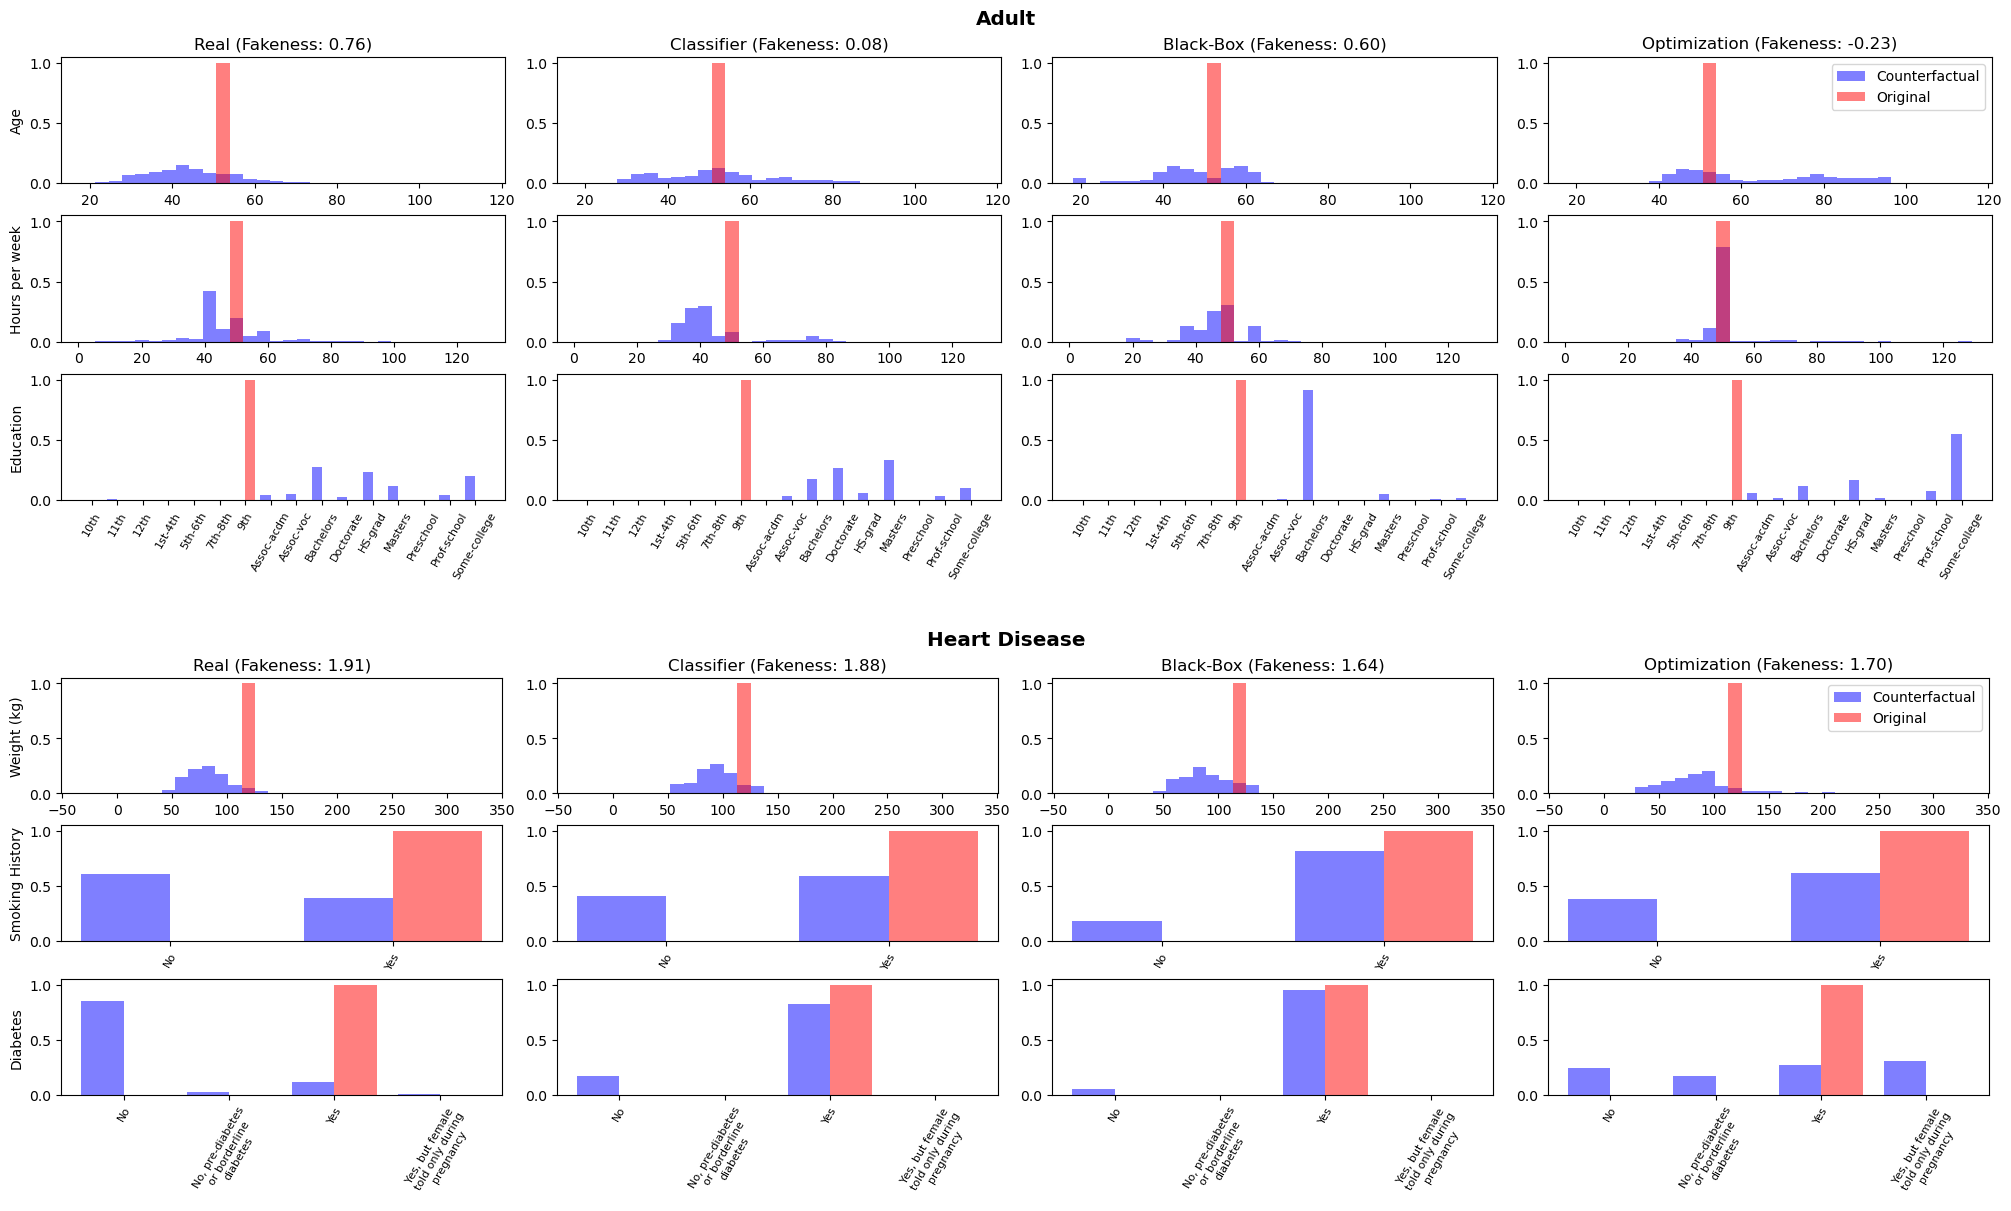

In [30]:
# LOAD DATA
with open("results2plot/whole_dist/adult_real_counterfactuals.pkl", "rb") as file:
    adult_real_counterfactuals = pickle.load(file)

with open("results2plot/whole_dist/adult_clas_counterfactuals.pkl", "rb") as file:
    adult_clas_counterfactuals = pickle.load(file)
        
with open("results2plot/whole_dist/adult_black_box_counterfactuals.pkl", "rb") as file:
    adult_black_box_counterfactuals = pickle.load(file)
        
with open("results2plot/whole_dist/adult_optim_counterfactuals.pkl", "rb") as file:
    adult_optim_counterfactuals = pickle.load(file)
        
with open("results2plot/whole_dist/heart_disease_real_counterfactuals.pkl", "rb") as file:
    heart_disease_real_counterfactuals = pickle.load(file)
        
with open("results2plot/whole_dist/heart_disease_clas_counterfactuals.pkl", "rb") as file:
    heart_disease_clas_counterfactuals = pickle.load(file)
        
with open("results2plot/whole_dist/heart_disease_black_box_counterfactuals.pkl", "rb") as file:
    heart_disease_black_box_counterfactuals = pickle.load(file)

with open("results2plot/whole_dist/heart_disease_optim_counterfactuals.pkl", "rb") as file:
    heart_disease_optim_counterfactuals = pickle.load(file)
    

with open("results2plot/whole_dist/adult_real_fakeness.pkl", "rb") as file:
    adult_real_fakeness = pickle.load(file)

with open("results2plot/whole_dist/adult_clas_fakeness.pkl", "rb") as file:
    adult_clas_fakeness = pickle.load(file)

with open("results2plot/whole_dist/adult_black_box_fakeness.pkl", "rb") as file:
    adult_black_box_fakeness = pickle.load(file)

with open("results2plot/whole_dist/adult_optim_fakeness.pkl", "rb") as file:
    adult_optim_fakeness = pickle.load(file)

with open("results2plot/whole_dist/heart_disease_real_fakeness.pkl", "rb") as file:
    heart_disease_real_fakeness = pickle.load(file)

with open("results2plot/whole_dist/heart_disease_clas_fakeness.pkl", "rb") as file:
    heart_disease_clas_fakeness = pickle.load(file)

with open("results2plot/whole_dist/heart_disease_black_box_fakeness.pkl", "rb") as file:
    heart_disease_black_box_fakeness = pickle.load(file)

with open("results2plot/whole_dist/heart_disease_optim_fakeness.pkl", "rb") as file:
    heart_disease_optim_fakeness = pickle.load(file)


# PLOTTING
features_to_plot = {
    "Adult": {"Age": "Age", "Hours per week": "Hours per week", "Education": "Education", },
    "Heart Disease": {"Weight_(kg)": "Weight (kg)", "Smoking_History": "Smoking History", "Diabetes": "Diabetes"}
}

replace_diabetes_labels = {
    "No, pre-diabetes or borderline diabetes": "No, pre-diabetes\nor borderline\ndiabetes",
    "Yes, but female told only during pregnancy": "Yes, but female\ntold only during\npregnancy"
}

counterfactuals = {
    "Adult": {
        "Real": adult_real_counterfactuals,
        "Classifier": adult_clas_counterfactuals,
        "Black-Box": adult_black_box_counterfactuals,
        "Optimization": adult_optim_counterfactuals,
    },
    "Heart Disease": {
        "Real": heart_disease_real_counterfactuals,
        "Classifier": heart_disease_clas_counterfactuals,
        "Black-Box": heart_disease_black_box_counterfactuals,
        "Optimization": heart_disease_optim_counterfactuals,
    }
}

fakeness = {
    "Adult": {
        "Real": adult_real_fakeness,
        "Classifier": adult_clas_fakeness,
        "Black-Box": adult_black_box_fakeness,
        "Optimization": adult_optim_fakeness,
    },
    "Heart Disease": {
        "Real": heart_disease_real_fakeness,
        "Classifier": heart_disease_clas_fakeness,
        "Black-Box": heart_disease_black_box_fakeness,
        "Optimization": heart_disease_optim_fakeness,
    }
}

originals = {
    "Adult": adult_samples,
    "Heart Disease": heart_disease_samples
}

# Determine number of rows and columns for the subplot grid
n_rows = max(len(features) for features in features_to_plot.values())
n_cols = max(len(counterfactuals[dataset]) for dataset in counterfactuals)

fig = plt.figure(layout='constrained', figsize=(5*n_cols, (2 * n_rows) * 2))
# fig.suptitle(f'Valid Counterfactual Distributions with 100% Flexibility\n', fontsize='xx-large')
subfigs = fig.subfigures(2, 1, hspace=0.07)

og_color = "red"
cf_color = "blue"

for i, (dataset, features) in enumerate(features_to_plot.items()):

    mosaic = [[feat + cf_type for cf_type in list(counterfactuals[dataset])] for feat in list(features_to_plot[dataset])]
    axs = subfigs[i].subplot_mosaic(mosaic)
    subfigs[i].suptitle(f'{dataset}', fontsize='x-large', fontweight='bold')

    for r, (feature_name, feature_label) in enumerate(features.items(), start=1):
        for c, (cf_type, cf_data) in enumerate(counterfactuals[dataset].items()):
            ax = axs[feature_name+cf_type]
            original_data = originals[dataset][feature_name].infer_objects()
            counterfactual_data = cf_data[feature_name]
            combined = pd.concat([cf_data[feature_name] for cf_data in counterfactuals[dataset].values()] + [originals[dataset][feature_name]], axis=0).reset_index(drop=True)

            if pd.api.types.is_numeric_dtype(original_data):
                bin_edges = np.histogram_bin_edges(combined, bins=30)
                og_weights = [1/len(original_data)] * len(original_data)
                cf_weights = [1/len(counterfactual_data)] * len(counterfactual_data)
                ax.hist(counterfactual_data, bins=bin_edges, weights=cf_weights, alpha=0.5, label='Counterfactual', color=cf_color)
                ax.hist(original_data, bins=bin_edges, weights=og_weights, alpha=0.5, label='Original', color=og_color)
            else:
                og_counts = original_data.value_counts(normalize=True)
                cf_counts = counterfactual_data.value_counts(normalize=True)
                combined_index = sorted(combined.value_counts().index)
                og_counts = og_counts.reindex(combined_index).fillna(0)
                cf_counts = cf_counts.reindex(combined_index).fillna(0)

                bar_width = 0.4
                indices = np.arange(len(og_counts))

                ax.bar(indices - bar_width / 2, cf_counts, bar_width, label='Counterfactual', color=cf_color, alpha=0.5)
                ax.bar(indices + bar_width / 2, og_counts, bar_width, label='Original', color=og_color, alpha=0.5)
                ax.set_xticks(indices)

                if feature_name == "Diabetes":
                    combined_index = [replace_diabetes_labels[l] if l in replace_diabetes_labels else l for l in combined_index]

                ax.set_xticklabels(combined_index, rotation=60, fontsize=8)

            if r == 1:
                ax.set_title(f'{cf_type} (Fakeness: {fakeness[dataset][cf_type]:.2f})', fontsize=12)
            if c == 0:
                ax.set_ylabel(f'{feature_label}', fontsize=10)
            if r == 1 and c == len(counterfactuals[dataset]) - 1:
                ax.legend()
        y_max = max([axs[feature_name+cf_type].get_ylim()[1] for cf_type in counterfactuals[dataset].keys()])
        
        for cf_type in counterfactuals[dataset].keys():
            axs[feature_name+cf_type].set_ylim(0, y_max)


save_path = "figures/whole_dist.png"
if save_path:
    plt.savefig(save_path, dpi=100, bbox_inches='tight')
else:
    plt.show()

### Load other data

In [281]:
# FLEXIBILITIES
with open("results2plot/flexibilities/adult_flexibilities.pkl", "rb") as file:
    adult_flexibilities = pickle.load(file)

adult_flexibilities["optimization"] = adult_flexibilities["optimization"].drop(index=0)

with open("results2plot/flexibilities/heart_disease_flexibilities.pkl", "rb") as file:
    heart_disease_flexibilities = pickle.load(file)

# COUNTERFACTUAL DISTRIBUTIONS
with open("results2plot/counterfactual_distributions/results.pkl", "rb") as file:
    results = pickle.load(file)

# CFGAN TUNING
with open("results2plot/cfgan_tune/real_tuning.pkl", "rb") as file:
    real_tuning = pickle.load(file)

# CONFUSION MATRICES
with open("results2plot/confusion_clas/confusion_matrices.pkl", "rb") as file:
    confusion_matrices = pickle.load(file)

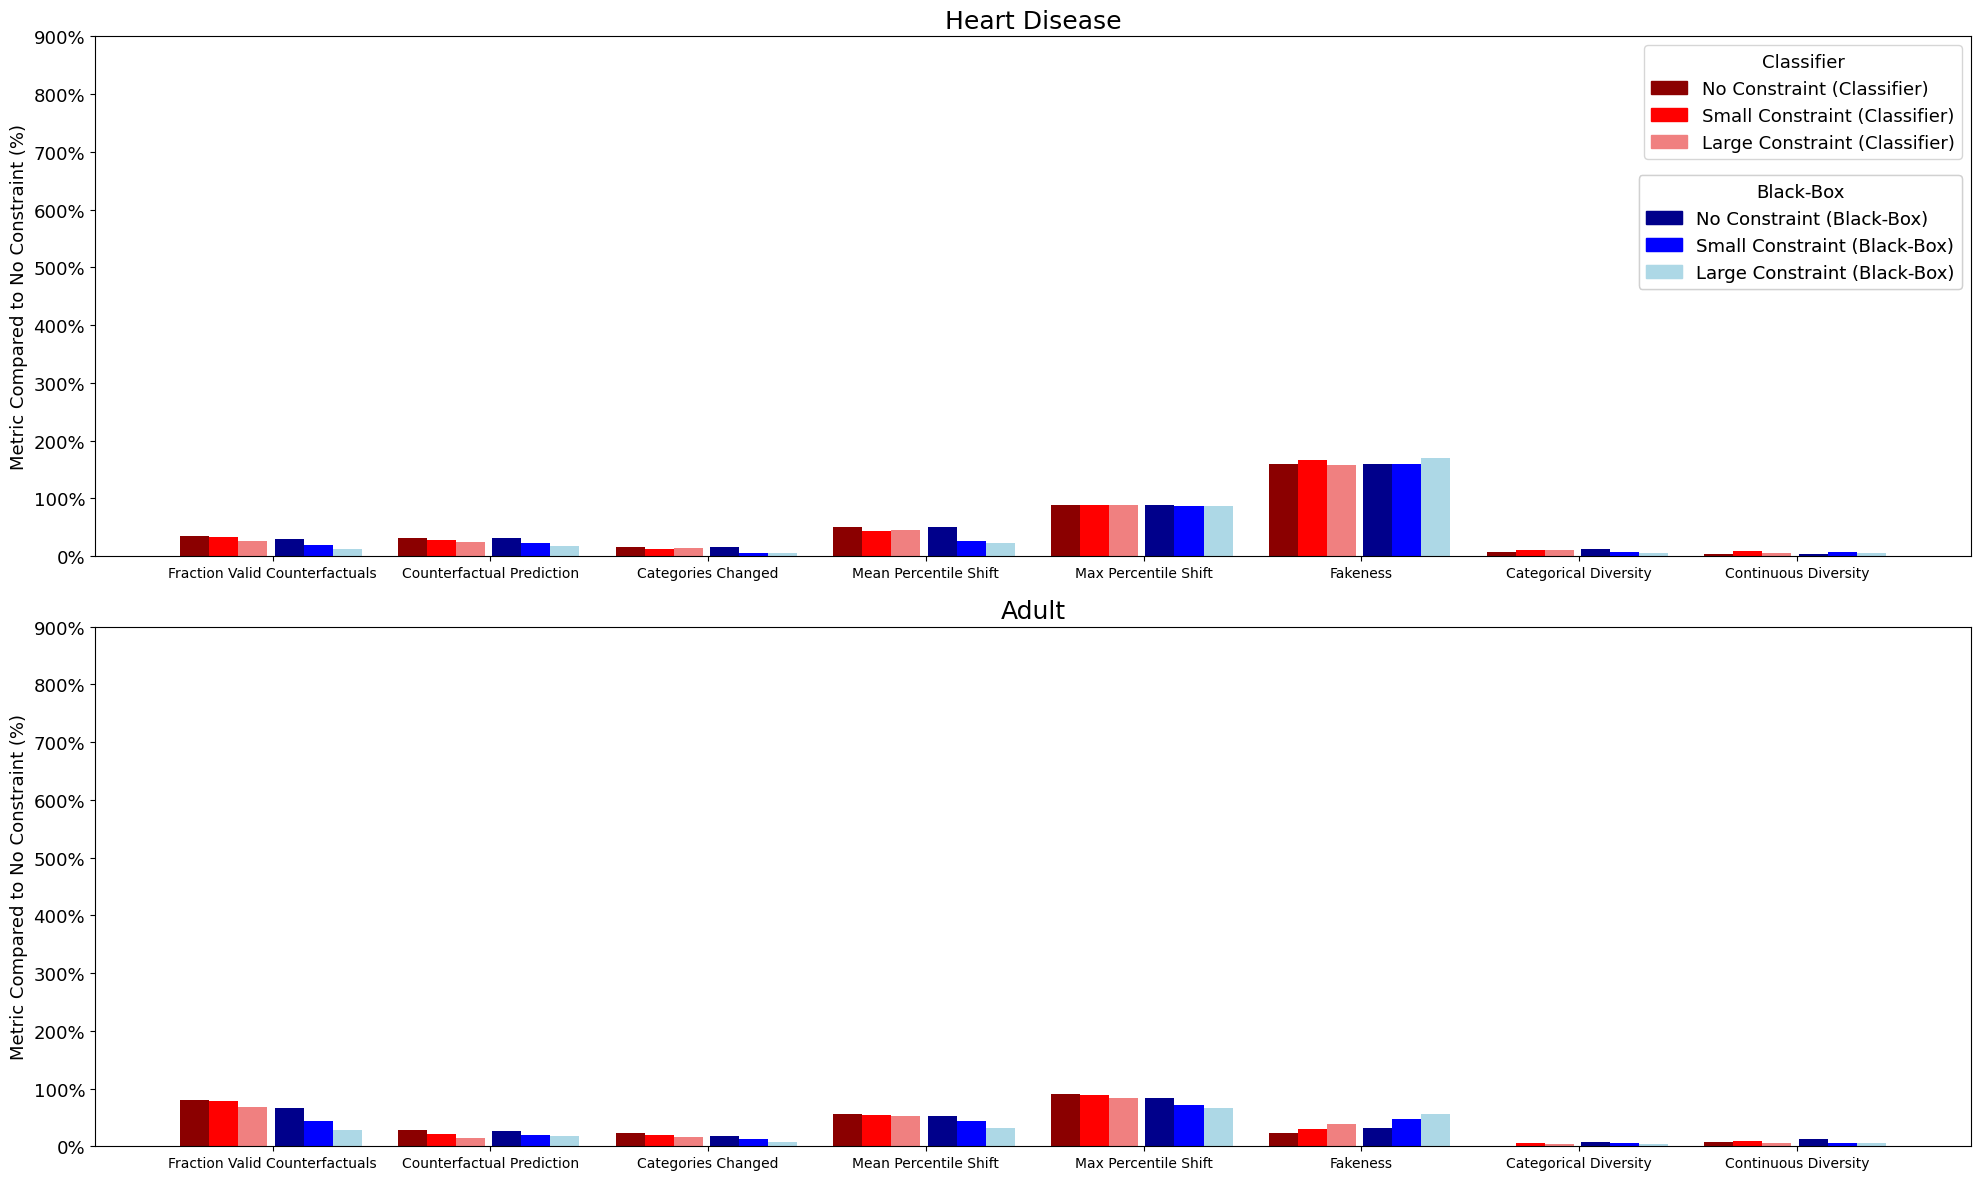

In [257]:
from sklearn.metrics import auc
import numpy as np

types = {
    "clas_cfgan_no_div": "classifier",
    "clas_cfgan_small_reconst_div": "classifier",
    "clas_cfgan_large_reconst_div": "classifier",
    "black_box_cfgan_no_div": "black-box",
    "black_box_cfgan_small_reconst_div": "black-box",
    "black_box_cfgan_large_reconst_div": "black-box",
}

metrics = ['valid_fraction',
           'cat_changed',
           'mean_percentile_shift',
           'max_percentile_shift',
           'counterfactual_prediction',
           'fakeness',
           'continuous_diversity',
           'categorical_diversity',
        ]

metric_labels = {
    "valid_fraction": "Fraction Valid Counterfactuals",
    "counterfactual_prediction": "Counterfactual Prediction",
    "cat_changed": "Categories Changed",
    "mean_percentile_shift": "Mean Percentile Shift", 
    "max_percentile_shift": "Max Percentile Shift", 
    "fakeness": "Fakeness",
    "categorical_diversity": "Categorical Diversity", 
    "continuous_diversity": "Continuous Diversity", 
}

colors = ['darkred', 'red', 'lightcoral', 'darkblue', 'blue', 'lightblue']

labels = ["No Constraint (Classifier)", 
          "Small Constraint (Classifier)",
           "Large Constraint (Classifier)",
           "No Constraint (Black-Box)",
           "Small Constraint (Black-Box)",
           "Large Constraint (Black-Box)"
           ]

flexibilities = {
    "Heart Disease": heart_disease_flexibilities,
    "Adult": adult_flexibilities,
}

# Plotting the AUC values for each column
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, axes = plt.subplots(2, 1, figsize=(20, 12))

for ax, (dataset_name, dataset_flexibilities) in zip(axes, flexibilities.items()):
    # Define bar width and positions
    bar_width = 0.2
    bar_positions = np.arange(len(metrics))

    # Plot bars for each type
    # Define the space between groups of bars
    group_space = 0.05
    category_space = 1.5

    first = None
    for i, ((exp, type), color, label) in enumerate(zip(types.items(), colors, labels)):
        if i % 3 == 0:
            first = {col: auc(dataset_flexibilities[exp].index, dataset_flexibilities[exp][col]) for col in metrics}
        # auc_values = {col: auc(dataset_flexibilities[exp].index, dataset_flexibilities[exp][col]) / first[col] for col in metrics}
        auc_values = {col: auc(dataset_flexibilities[exp].index, dataset_flexibilities[exp][col]) for col in metrics}
        group_index = i // 3  # Determine the group index
        bar_positions_shifted = bar_positions * category_space + i * bar_width + group_index * group_space
        ax.bar(bar_positions_shifted, list(auc_values.values()), width=bar_width, label=label, color=color)

    # Set y-ticks to be per 100% step
    ax.yaxis.set_major_locator(plt.MultipleLocator(1.0))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y * 100)}%'))

    # Set the tick positions and labels
    total_groups = (len(types) + 1) // 2
    xtick_positions = bar_positions * category_space + (bar_width * (total_groups + 2) + group_space * (total_groups) / 2) / 2
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(list(metric_labels.values()), fontsize=10)

    # Set labels and title
    ax.set_ylabel('Metric Compared to No Constraint (%)')
    ax.set_title(f'{dataset_name}', fontsize=18)

# Add horizontal line at 100% for reference
# for ax in axes:
#     ax.axhline(y=1, color='gray', linestyle='--', linewidth=1)

# Set the same y-axis scale for both subplots
axes[0].set_ylim(0, 9)
axes[1].set_ylim(0, 9)

# Create custom legend handles for classifier and black-box
classifier_patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(3)]
black_box_patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(3, 6)]

# Add the classifier legend
legend1 = axes[0].legend(handles=classifier_patches, title="Classifier", loc='upper right')

# Add the black-box legend
legend2 = axes[0].legend(handles=black_box_patches, title="Black-Box", loc='upper right', bbox_to_anchor=(1, 0.75))

# Add the legends to the axis
axes[0].add_artist(legend1)
axes[0].add_artist(legend2)

# Adjust the layout to accommodate the legends
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


Heart Disease
-0.046305527096722074 1.1
-0.04997469802900214 1.1
-0.29220364336361715 1.1
-0.23529693628362688 1.1
0.03474629944600001 1.1
0.0689922019605181 1.1
-0.019272532367319278 1.1
-0.13006628756834124 1.1
-0.30468431632576676 1.1
-0.687769667988366 1.1
-0.607174590222215 1.1
0.042183859593503584 1.1
0.27559838389789804 1.1
-0.1514241147585791 1.1
-0.32438156796998036 1.1
-0.16074161643728702 1.1
-0.4374952654766628 1.1
-0.38510204898953904 1.1
0.038380883410757606 1.1
-0.41308503811486563 1.1
0.3838241953221023 1.1
-0.5833577645999845 1.1
-0.41772767204052635 1.1
-0.7026036435354948 1.1
-0.6581817206191397 1.1
0.011114991883386032 1.1
0.5791851326256713 1.1
0.23224097793611737 1.1
Diabetes
-0.06010378213558981 1.1
-0.12109242416818193 1.1
-0.17960986255741146 1.1
-0.13222332356467764 1.1
0.01051134521047517 1.1
0.0563784572937021 1.1
-0.05885874079308316 1.1
-0.20881404139849322 1.1
-0.26799310515060953 1.1
-0.5240783788452041 1.1
-0.43836131972636194 1.1
-0.031357774218989484 

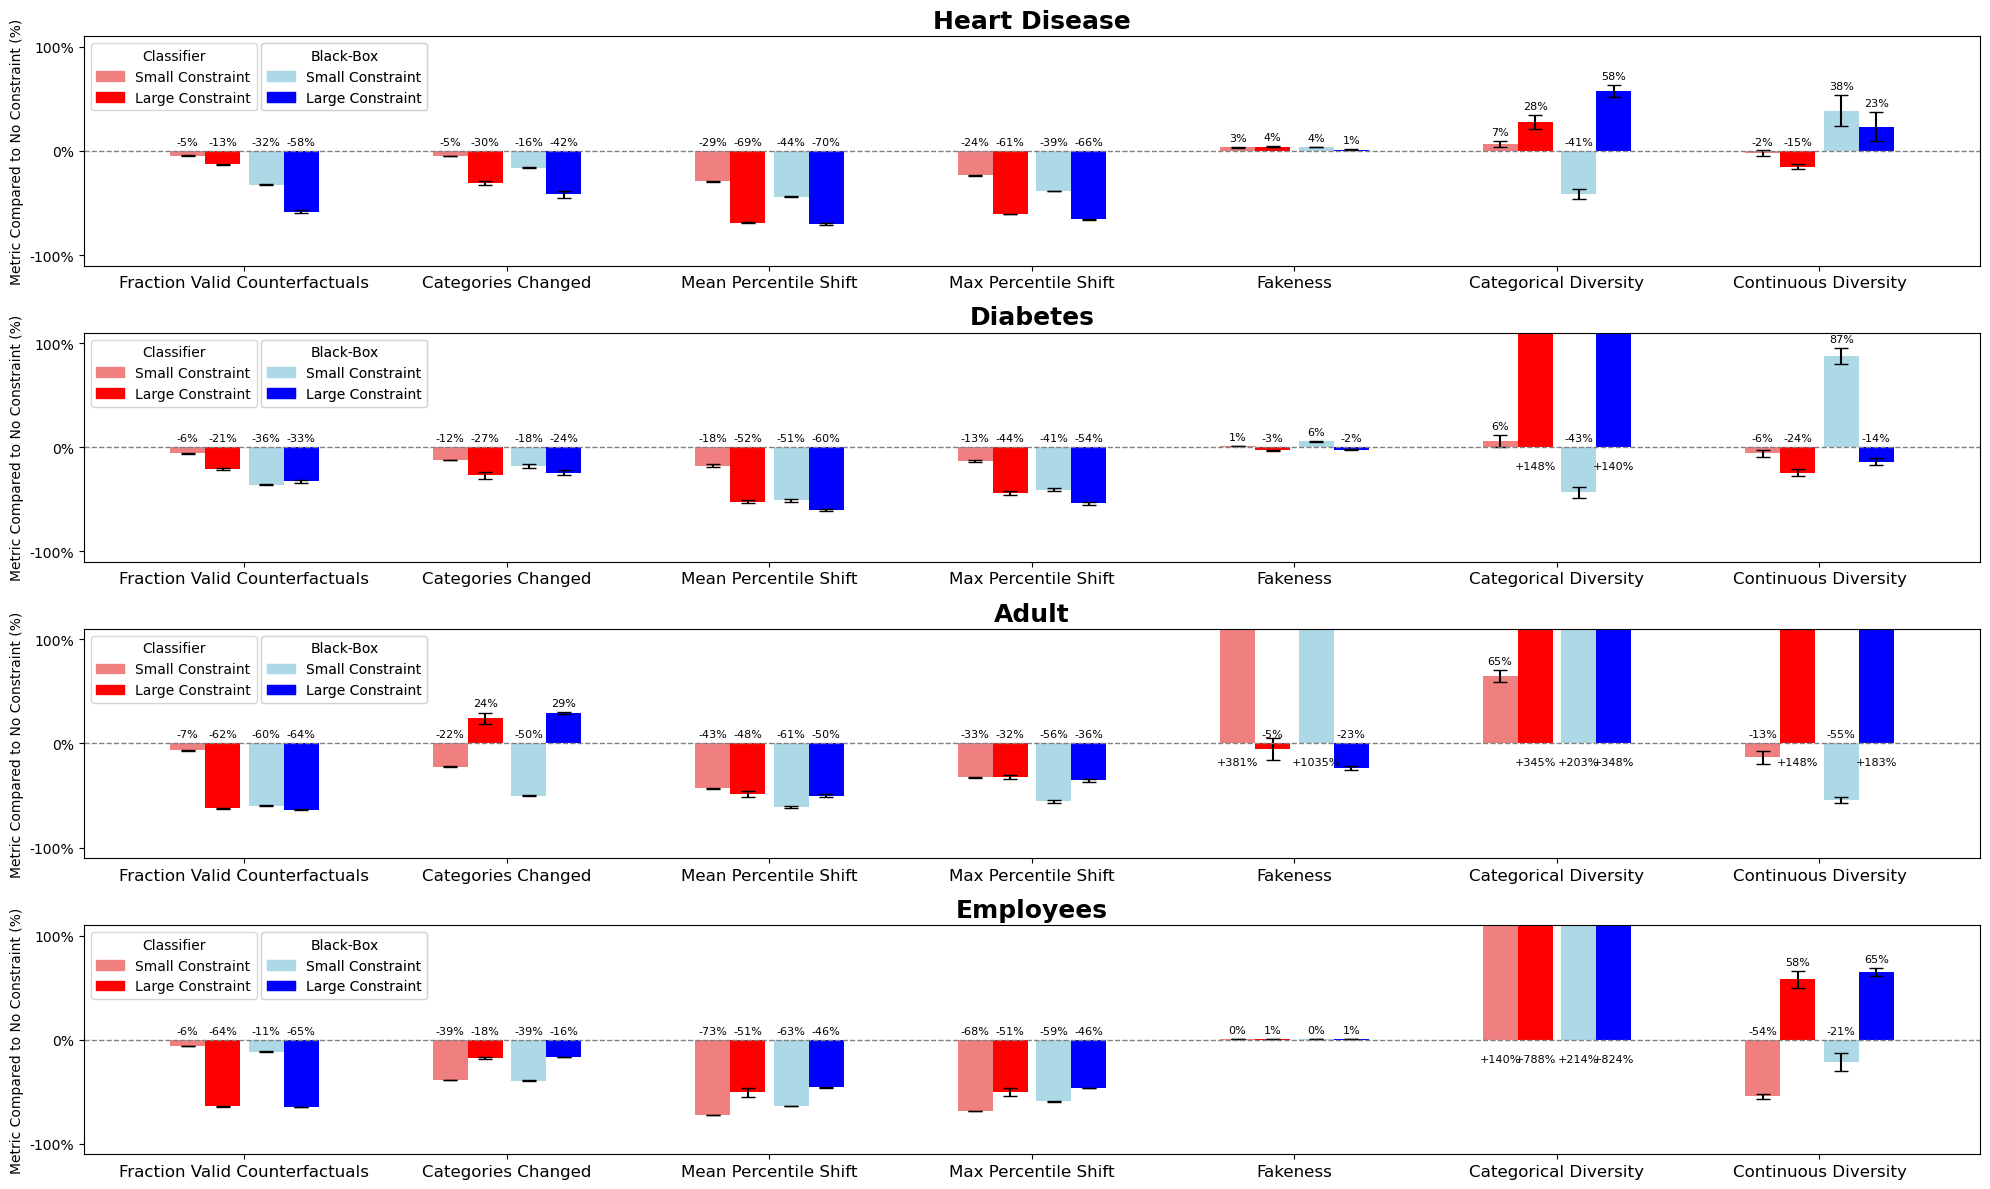

In [97]:
from sklearn.metrics import auc
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

types = {
    # "clas_cfgan_no_div": "classifier",
    "clas_cfgan_cf_div=10": "classifier",
    "clas_cfgan_cf_div=100": "classifier",
    # "optimization-clas": "classifier",
    # "black_box_cfgan_no_div": "black-box",
    "black_box_cfgan_cf_div=5": "black-box",
    "black_box_cfgan_cf_div=50": "black-box",
    # "optimization-black-box": "black-box",
}

metrics = ['valid_fraction',
           'cat_changed',
           'mean_percentile_shift',
           'max_percentile_shift',
        #    'counterfactual_prediction',
           'fakeness',
           'continuous_diversity',
           'categorical_diversity',
        ]

metric_labels = {
    "valid_fraction": "Fraction Valid Counterfactuals",
    # "counterfactual_prediction": "Counterfactual Prediction",
    "cat_changed": "Categories Changed",
    "mean_percentile_shift": "Mean Percentile Shift", 
    "max_percentile_shift": "Max Percentile Shift", 
    "fakeness": "Fakeness",
    "categorical_diversity": "Categorical Diversity", 
    "continuous_diversity": "Continuous Diversity", 
}

dataset_names = {"heart_disease": "Heart Disease",
                 "diabetes": "Diabetes", 
                 "adult": "Adult",
                 "employees": "Employees"
                 }


colors = ['darkred', 'red', 'lightcoral', 'darkblue', 'blue', 'lightblue']
colors = ['lightcoral', 'red', 'lightblue', 'blue']

labels = ["Small Constraint",
           "Large Constraint",
           "Small Constraint",
           "Large Constraint"
           ]

# with open("experiments2/results/flexibilities.pkl", "rb") as file:
#     flexibilities = pickle.load(file)

# plot_flexibilities = {
#     "Heart Disease": flexibilities["simple"]["heart_disease"],
#     "Diabetes": flexibilities["simple"]["diabetes"],
#     "Adult": flexibilities["simple"]["adult"],
#     "Employees": flexibilities["simple"]["employees"],
# }

# Initialize an empty dictionary to store combined flexibilities
combined_flexibilities = {
    "Heart Disease": [],
    "Diabetes": [],
    "Adult": [],
    "Employees": [],
}

# Iterate over the five files and load the flexibilities
for i in range(1, 6):
    with open(f"experiments2/results/flexibilities{i}.pkl", "rb") as file:
        flexibilities = pickle.load(file)
        for dataset, dataset_label in dataset_names.items():
            combined_flexibilities[dataset_label].append(flexibilities["simple"][dataset])

# Combine the flexibilities for each dataset
plot_flexibilities = {dataset: {key: [item[key] for item in combined_flexibilities[dataset]] for key in combined_flexibilities[dataset][1]} for dataset in combined_flexibilities}


fig, axes = plt.subplots(4, 1, figsize=(20, 12))

for ax, (dataset_name, dataset_flexibilities) in zip(axes, plot_flexibilities.items()):
    # Define bar width and positions
    bar_width = 0.2
    bar_positions = np.arange(len(metrics))

    # Plot bars for each type
    # Define the space between groups of bars
    group_space = 0.05
    category_space = 1.5

    first = [
        {col: np.mean([auc(flex.index, flex[col]) for flex in dataset_flexibilities["clas_cfgan_no_div"]]) for col in metrics},
        {col: np.mean([auc(flex.index, flex[col]) for flex in dataset_flexibilities["black_box_cfgan_no_div"]]) for col in metrics}
    ]
    print(dataset_name)
    for i, ((exp, type), color, label) in enumerate(zip(types.items(), colors, labels)):
        auc_values = {col: np.mean([(auc(flex.index, flex[col])) for flex in dataset_flexibilities[exp]]) for col in metrics}
        auc_values = {col: [(auc(flex.index, flex[col]) - first[i % 2][col]) / abs(first[i % 2][col]) for flex in dataset_flexibilities[exp]] for col in metrics}
        mean_auc_values = {col: np.mean(auc_values[col]) for col in metrics}
        sem_auc_values = {col: np.std(auc_values[col]) / np.sqrt(len(auc_values[col])) for col in metrics}
        
        group_index = i // 2  # Determine the group index
        bar_positions_shifted = bar_positions * category_space + i * bar_width + group_index * group_space
        bars = ax.bar(bar_positions_shifted, list(mean_auc_values.values()), yerr=list(sem_auc_values.values()), width=bar_width, label=label, color=color, capsize=5)
        ax.set_ylim(-1.1, 1.1)

        # Add markers for values outside the y-limits
        for bar, error in zip(bars, list(sem_auc_values.values())):
            height = bar.get_height()
            print(height, ax.get_ylim()[1])

            if height > ax.get_ylim()[1]:
                print("jow")
                ax.annotate(f'+{height*100:.0f}%', xy=(bar.get_x() + bar.get_width() / 2, 0), 
                            xytext=(0, -10), textcoords="offset points", ha='center', va='top', color='black', fontsize=8)
            elif height < ax.get_ylim()[0]:
                ax.annotate(f'{height*100:.0f}%', xy=(bar.get_x() + bar.get_width() / 2, 0), 
                            xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', color='black', fontsize=8)
            elif height > 0:
                ax.annotate(f'{height*100:.0f}%', xy=(bar.get_x() + bar.get_width() / 2, height + error), 
                            xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', color='black', fontsize=8)
            else:
                ax.annotate(f'{height*100:.0f}%', xy=(bar.get_x() + bar.get_width() / 2, 0), 
                            xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', color='black', fontsize=8)

    # Set y-ticks to be per 100% step
    ax.yaxis.set_major_locator(plt.MultipleLocator(1.0))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y * 100)}%'))

    # Set the tick positions and labels
    total_groups = (len(types) + 1) // 2
    xtick_positions = bar_positions * category_space + (bar_width * (total_groups + 1) + group_space * (total_groups) / 2) / 2
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(list(metric_labels.values()), fontsize=12)

    # Set labels and title
    ax.set_ylabel('Metric Compared to No Constraint (%)', fontsize=10)
    ax.set_title(f'{dataset_name}', fontsize=18, fontweight='bold')
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1)

    

# Create custom legend handles for classifier and black-box
classifier_patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(2)]
black_box_patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(2, 4)]

for ax in axes:
    # Add the classifier legend
    legend1 = ax.legend(handles=classifier_patches, title="Classifier", loc='upper left')

    # Add the black-box legend
    legend2 = ax.legend(handles=black_box_patches, title="Black-Box", loc='upper left', bbox_to_anchor=(0.09, 1))

    # Add the legends to the axis
    ax.add_artist(legend1)
    ax.add_artist(legend2)

# Adjust the layout to accommodate the legends
plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig(f"figures/divergence.png", dpi=100, bbox_inches='tight')


dict_keys(['clas_cfgan_no_div', 'clas_cfgan_small_reconst_div', 'clas_cfgan_large_reconst_div', 'black_box_cfgan_no_div', 'black_box_cfgan_small_reconst_div', 'black_box_cfgan_large_reconst_div', 'clas_cfgan_cf_div=10', 'clas_cfgan_cf_div=100', 'black_box_cfgan_cf_div=5', 'black_box_cfgan_cf_div=50', 'class_no_template_cfgan', 'black_box_no_template_cfgan', 'template_optimization_no_div', 'default_optimization_no_div'])
first [[     cat_changed  cat_changed_sem  mean_percentile_shift  \
0.0     0.000000         0.000000               0.000000   
0.1     0.051661         0.000638               0.025308   
0.2     0.099974         0.000724               0.060254   
0.3     0.150281         0.000795               0.096604   
0.4     0.202365         0.000812               0.131933   
0.5     0.249034         0.000812               0.168462   
0.6     0.271629         0.000797               0.186059   
0.7     0.313863         0.000748               0.221292   
0.8     0.356783         0.0

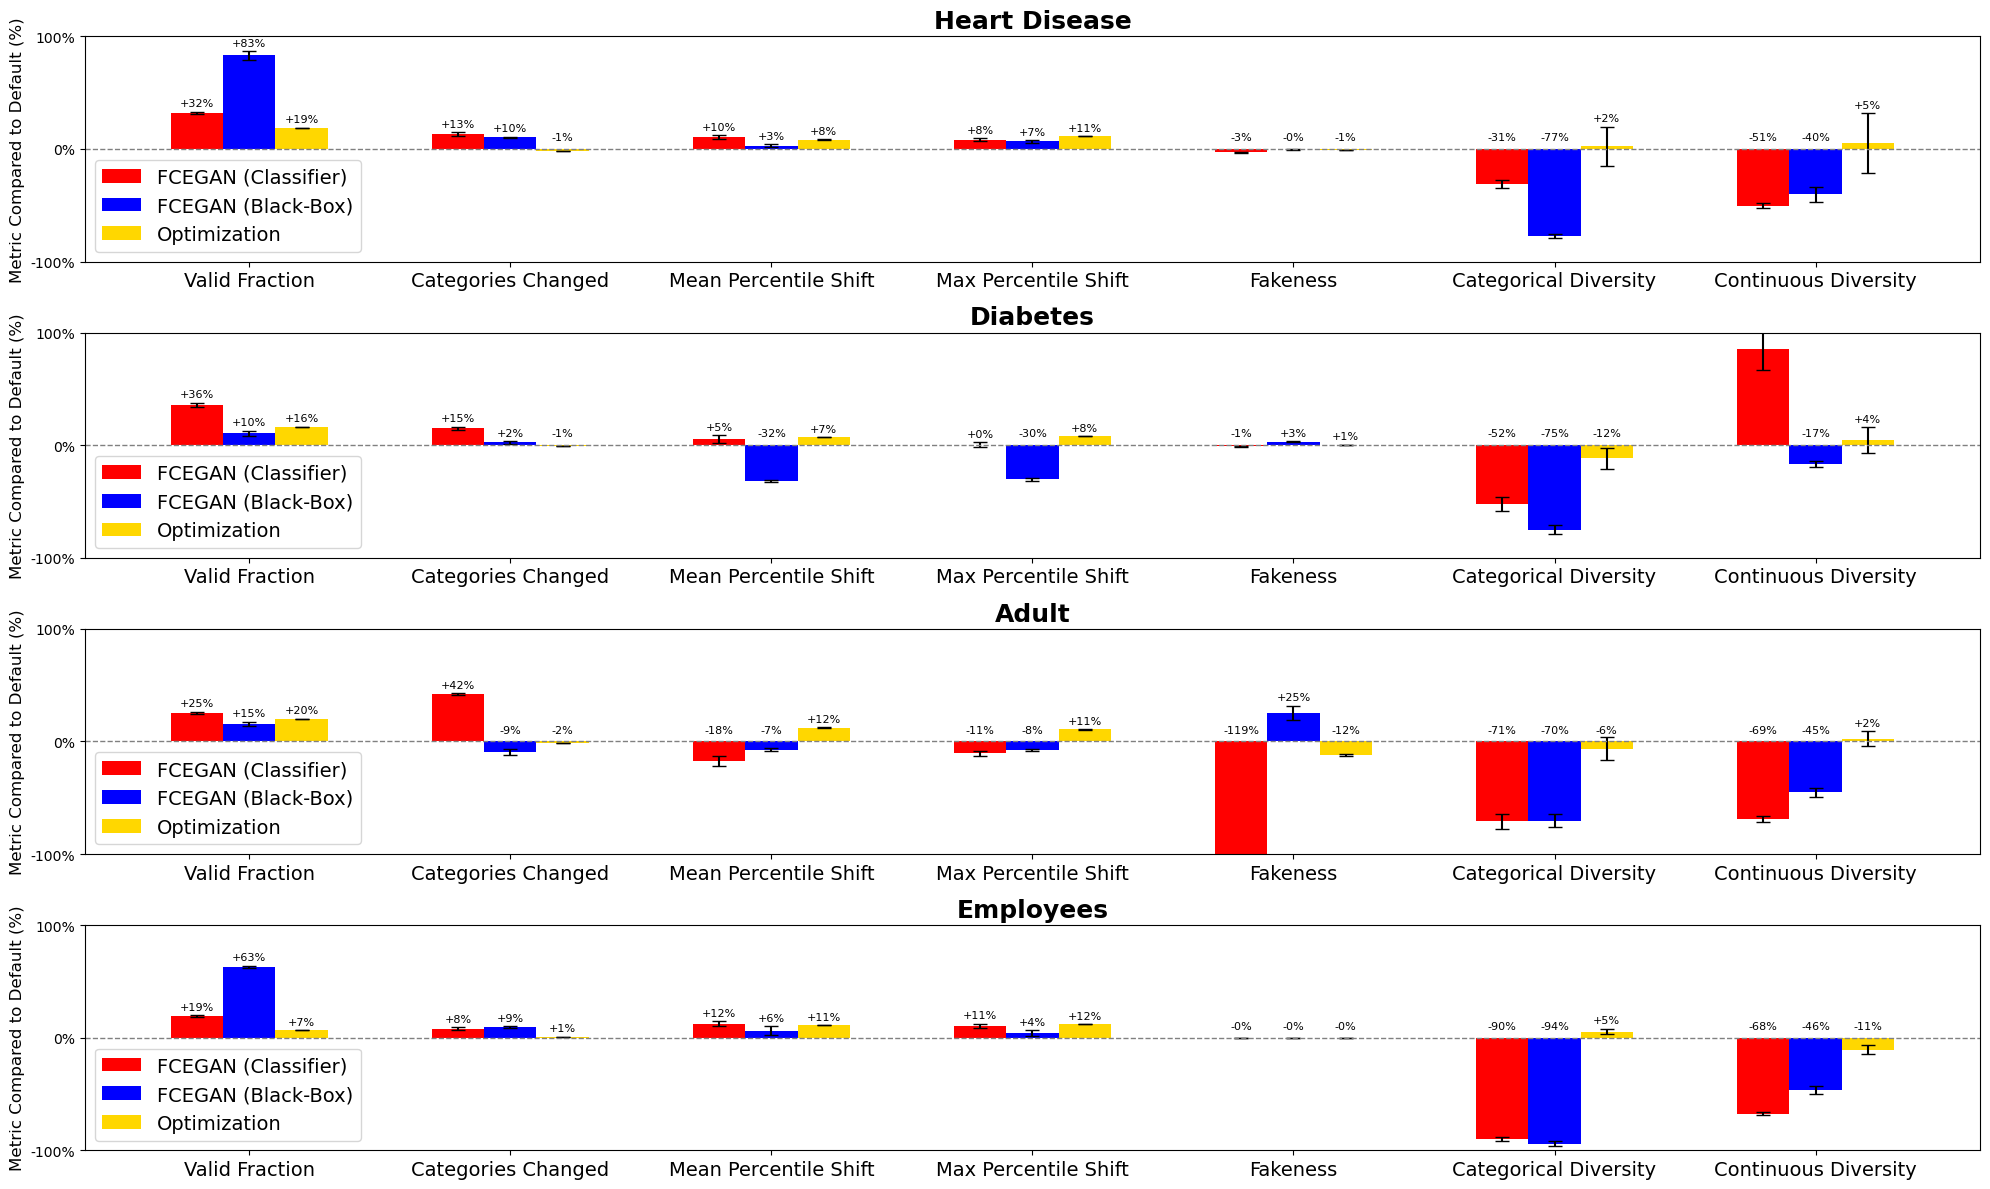

In [84]:
from sklearn.metrics import auc
import numpy as np

dataset_names = {"heart_disease": "Heart Disease",
                 "diabetes": "Diabetes", 
                 "adult": "Adult",
                 "employees": "Employees"
                 }

# Initialize an empty dictionary to store combined flexibilities
combined_flexibilities = {
    "Heart Disease": [],
    "Diabetes": [],
    "Adult": [],
    "Employees": [],
}

# Iterate over the five files and load the flexibilities
for i in range(1, 6):
    with open(f"experiments2/results/flexibilities{i}.pkl", "rb") as file:
        flexibilities = pickle.load(file)
        for dataset, dataset_label in dataset_names.items():
            combined_flexibilities[dataset_label].append(flexibilities["simple"][dataset])

# Combine the flexibilities for each dataset
plot_flexibilities = {dataset: {key: [item[key] for item in combined_flexibilities[dataset]] for key in combined_flexibilities[dataset][1]} for dataset in combined_flexibilities}

types = {
    "clas_cfgan_no_div": "classifier",
    "black_box_cfgan_no_div": "black-box",
    "template_optimization_no_div": "optimizer",
}

metrics = ['valid_fraction',
           'cat_changed',
           'mean_percentile_shift',
           'max_percentile_shift',
           'fakeness',
           'continuous_diversity',
           'categorical_diversity',
        ]

metric_labels = {
    "valid_fraction": "Valid Fraction",
    "cat_changed": "Categories Changed",
    "mean_percentile_shift": "Mean Percentile Shift", 
    "max_percentile_shift": "Max Percentile Shift", 
    "fakeness": "Fakeness",
    "categorical_diversity": "Categorical Diversity", 
    "continuous_diversity": "Continuous Diversity", 
}

colors = ['red', 'blue', 'gold']

labels = ["FCEGAN (Classifier)",
           "FCEGAN (Black-Box)",
           "Optimization",
           ]

letters = ["A", "B", "C", "D"]

fig, axes = plt.subplots(4, 1, figsize=(20, 12))

for ax, (dataset_name, dataset_flexibilities) in zip(axes, plot_flexibilities.items()):
    # Define bar width and positions
    bar_width = 0.2
    bar_positions = np.arange(len(metrics))

    print(dataset_flexibilities.keys())


    first = [
        {col: np.mean([auc(flex.index, flex[col]) for flex in dataset_flexibilities["class_no_template_cfgan"]]) for col in metrics},
        {col: np.mean([auc(flex.index, flex[col]) for flex in dataset_flexibilities["black_box_no_template_cfgan"]]) for col in metrics},
        {col: np.mean([auc(flex.index, flex[col]) for flex in dataset_flexibilities["default_optimization_no_div"]]) for col in metrics}
    ]
    first = [
        dataset_flexibilities["class_no_template_cfgan"],
        dataset_flexibilities["black_box_no_template_cfgan"],
        dataset_flexibilities["default_optimization_no_div"]
    ]

    print("first", first)

    all_bars = []
    all_errors = []  

    for i, ((exp, type), color, label) in enumerate(zip(types.items(), colors, labels)):
        auc_values = {col: [(auc(flex.index, flex[col]) - auc(first_flex.index, first_flex[col]))/abs(auc(first_flex.index, first_flex[col])) for flex, first_flex in zip(dataset_flexibilities[exp], first[i])] for col in metrics}
        
        # mean_values = {col: (np.mean(auc_values[col]) - first[i][col])/abs(first[i][col]) for col in metrics}
        # sem_values = {col: np.std(auc_values[col]) / np.sqrt(len(dataset_flexibilities[exp])) for col in metrics}

        mean_values = {col: np.mean(auc_values[col]) for col in metrics}
        sem_values = {col: np.std(auc_values[col]) / np.sqrt(len(dataset_flexibilities[exp])) for col in metrics}

        bar_positions_shifted = bar_positions + i * bar_width
        bars = ax.bar(
            bar_positions_shifted,
            list(mean_values.values()),
            yerr=list(sem_values.values()),
            width=bar_width,
            label=label,
            color=color,
            capsize=5
        )
        all_bars.append(bars)
        # Save the errors in the same order as the bars
        # Here, we assume the order of sem_values is the same as list(mean_values.values())
        errors_for_bars = list(sem_values.values())
        all_errors.append(errors_for_bars)
    # Set y-ticks to be per 100% step
    ax.yaxis.set_major_locator(plt.MultipleLocator(1.0))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y * 100)}%'))

    # Set the tick positions and labels
    total_groups = (len(types) + 1) // 2
    xtick_positions = bar_positions + (len(types) - 1) * (bar_width) / 2
    ax.set_xticks(xtick_positions)

    ax.set_xticklabels(list(metric_labels.values()), fontsize=14)

    # if dataset_name == "Employees":
    #     ax.set_xticklabels(list(metric_labels.values()), fontsize=14)
    # else:
    #     ax.set_xticklabels([])

    # Set labels and title
    ax.set_ylabel('Metric Compared to Default (%)', fontsize=12)
    # ax.text(0.5, 0.95, f'{dataset_name}', 
    #         transform=ax.transAxes, fontsize=18, ha='center', va='top', fontweight='bold')
    ax.set_title(f'{dataset_name}', fontsize=18, loc='center', fontweight='bold')

    # Add horizontal line at 100% for reference
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1)
    # Set the same y-axis scale for both subplots
    ax.set_ylim(-1, 1)

    # Add markers for values outside the y-limits
    for bars, errors in zip(all_bars, all_errors):
        for bar, error in zip(bars, errors):
            mean_val = bar.get_height()
            y_annotation = mean_val + error + 0.03  # Adjust offset as needed
            
            # Format the annotation text (add '+' sign if positive)
            text = f'+{mean_val*100:.0f}%' if mean_val > 0 else f'{mean_val*100:.0f}%'

            if mean_val > 0:
                ax.annotate(
                    text,
                    xy=(bar.get_x() + bar.get_width()/2, y_annotation),
                    xytext=(0, 0),
                    textcoords="offset points",
                    ha='center',
                    va='bottom',
                    fontsize=8,
                    color='black'
                )
            else:
                ax.annotate(
                    text,
                    xy=(bar.get_x() + bar.get_width()/2, 0.15),
                    xytext=(0, 0),
                    textcoords="offset points",
                    ha='center',
                    va='top',
                    fontsize=8,
                    color='black'
                )

    # if dataset_name == "Diabetes":
    #     ax.legend(loc='lower right', fontsize=14)
    # else:
    #     ax.legend(loc='upper right', fontsize=14)
    ax.legend(loc='lower left', fontsize=14)

# fig.suptitle("Impact of Counterfactual Templates", fontsize=20, fontweight='bold')
# Adjust the layout to accommodate the legends
plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig(f"figures/counterfactual_template_metrics.png", dpi=100, bbox_inches='tight')


### Flexibilities

simple
ctgan


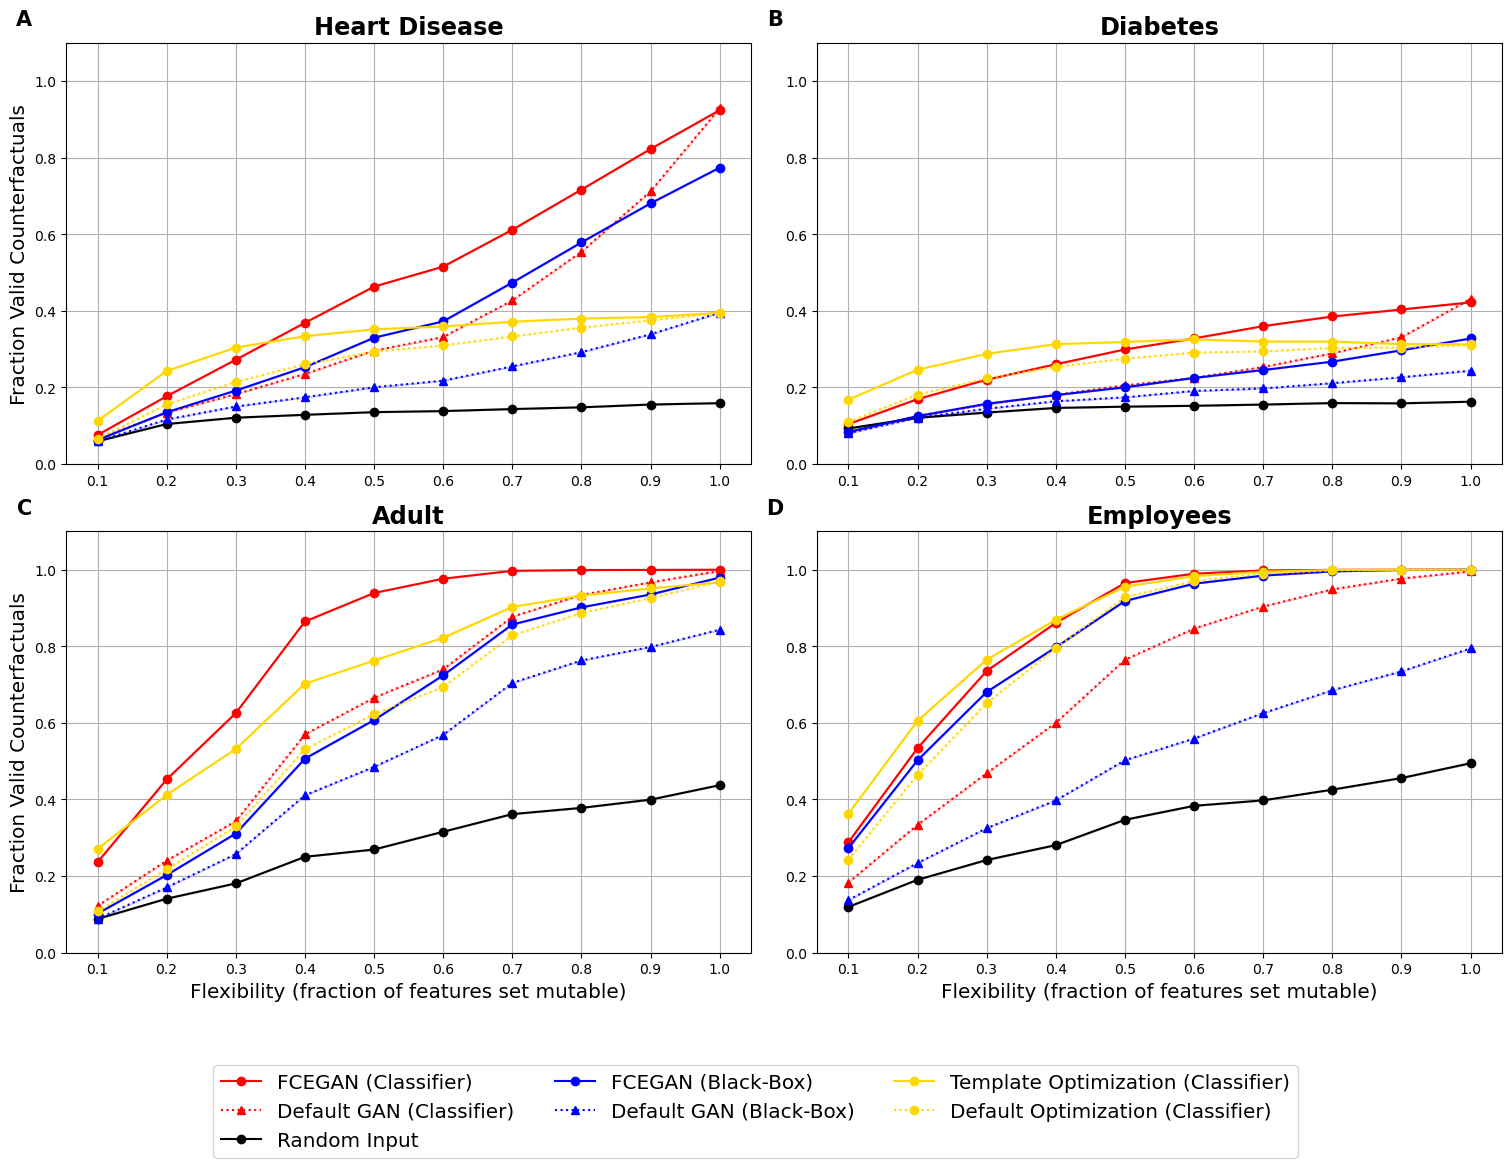

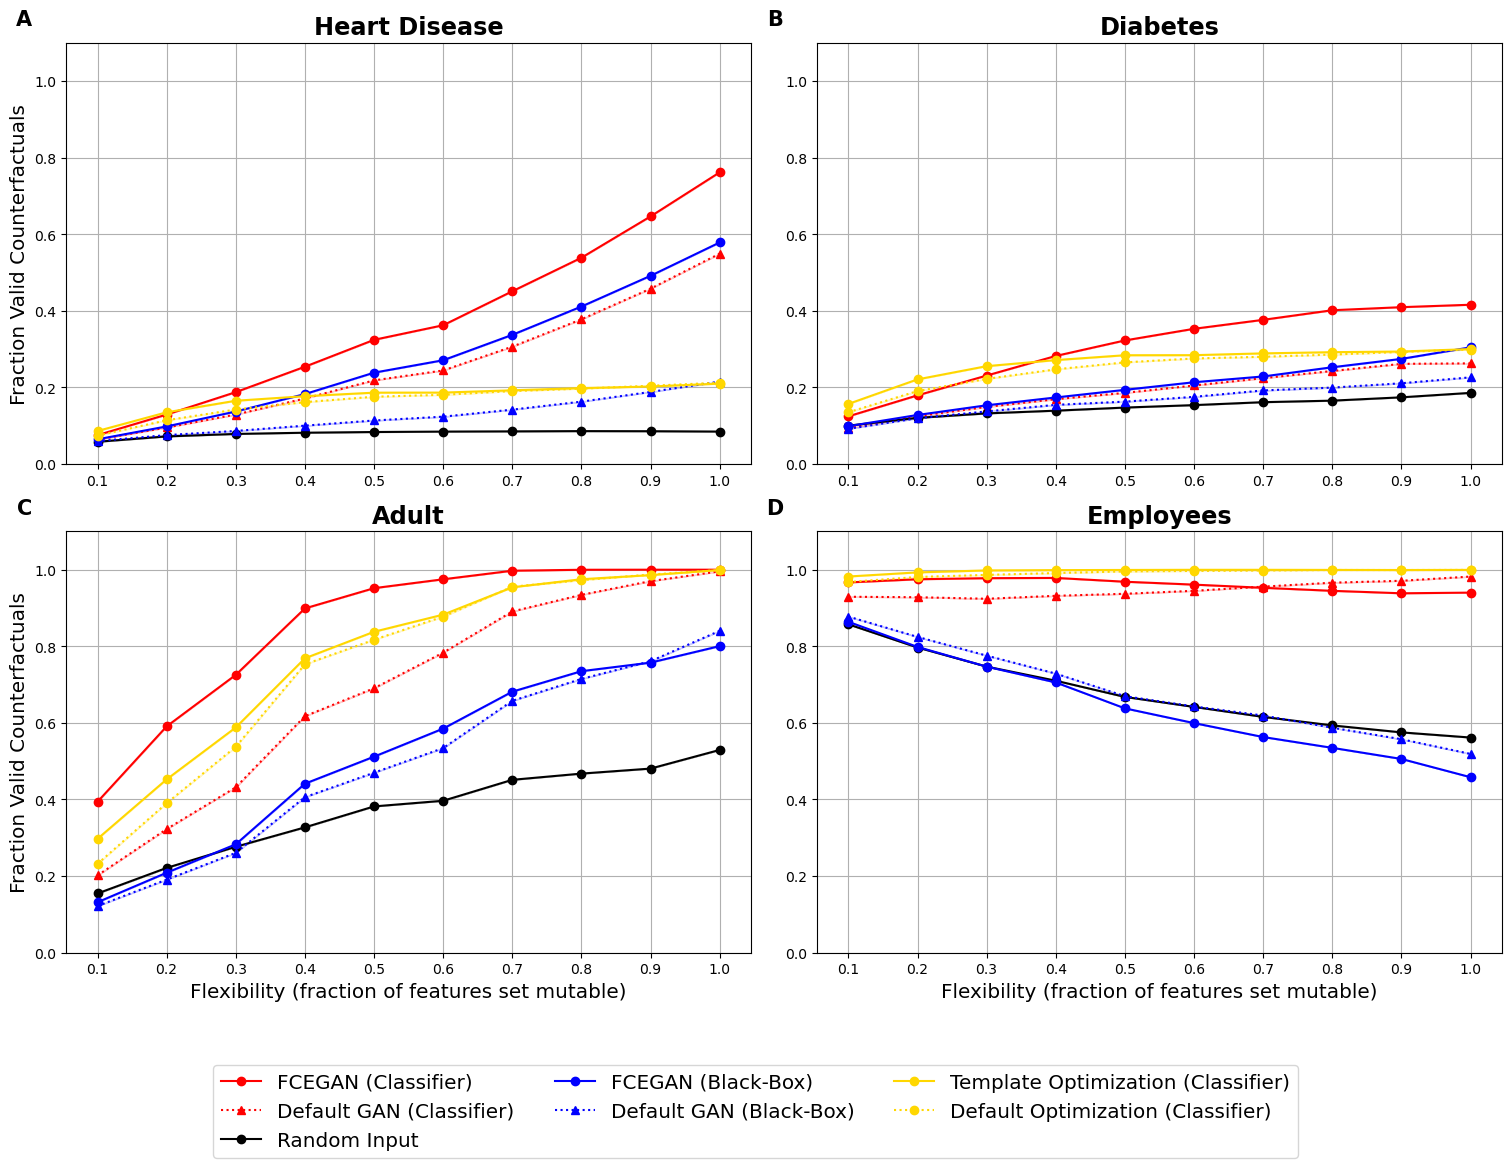

In [137]:
with open("experiments2/results/flexibilities.pkl", "rb") as file:
    flexibilities = pickle.load(file)

experiments = {
    'clas_cfgan_no_div': {'label': 'FCEGAN (Classifier)', 'color': 'red', 'line_style': 'solid', 'marker': 'o'}, 
    'class_no_template_cfgan': {'label': 'Default GAN (Classifier)', 'color': 'red', 'line_style': 'dotted', 'marker': '^'},  
    'random': {'label': 'Random Input', 'color': 'black', 'line_style': 'solid', 'marker': 'o'}, 
    'black_box_cfgan_no_div': {'label': 'FCEGAN (Black-Box)', 'color': 'blue', 'line_style': 'solid', 'marker': 'o'}, 
    'black_box_no_template_cfgan': {'label': 'Default GAN (Black-Box)', 'color': 'blue', 'line_style': 'dotted', 'marker': '^'}, 
    # 'no_template_cfgan': {'label': 'GAN (Classifier)', 'color': 'purple', 'line_style': 'solid', 'marker': 'o'}, 
    
    'template_optimization_no_div': {'label': 'Template Optimization (Classifier)', 'color': 'gold', 'line_style': 'solid', 'marker': 'o'}, 
    'default_optimization_no_div': {'label': 'Default Optimization (Classifier)', 'color': 'gold', 'line_style': 'dotted', 'marker': 'o'},
    # 'default_optimization_no_div': {'label': 'Optimization (Classifier)', 'color': 'brown', 'line_style': 'solid', 'marker': 'o'},
    # 'template_optimization_with_div': {'label': 'No CTGAN Black-Box', 'color': 'magenta', 'line_style': 'solid', 'marker': 'o'},
    }

# experiments = {
#     'clas_cfgan_no_div': {'label': 'FCEGAN (Classifier)', 'color': 'red', 'line_style': 'solid', 'marker': 'o'}, 
#     'clas_cfgan_small_reconst_div': {'label': 'Default GAN (Classifier)', 'color': 'red', 'line_style': 'dotted', 'marker': '^'},
#     'clas_cfgan_large_reconst_div': {'label': 'Default GAN (Classifier)', 'color': 'red', 'line_style': 'dashdot', 'marker': '^'},  
#     # 'random': {'label': 'Random Input', 'color': 'black', 'line_style': 'solid', 'marker': 'o'}, 
#     'black_box_cfgan_no_div': {'label': 'FCEGAN (Black-Box)', 'color': 'blue', 'line_style': 'solid', 'marker': 'o'}, 
#     'black_box_cfgan_small_reconst_div': {'label': 'Default GAN (Black-Box)', 'color': 'blue', 'line_style': 'dotted', 'marker': '^'},
#     'black_box_cfgan_large_reconst_div': {'label': 'Default GAN (Black-Box)', 'color': 'blue', 'line_style': 'dashdot', 'marker': '^'}, 
#     # 'no_template_cfgan': {'label': 'GAN (Classifier)', 'color': 'purple', 'line_style': 'solid', 'marker': 'o'}, 
    
#     # 'template_optimization_no_div': {'label': 'Template Optimization (Classifier)', 'color': 'gold', 'line_style': 'solid', 'marker': 'o'}, 
#     # 'default_optimization_no_div': {'label': 'Default Optimization (Classifier)', 'color': 'gold', 'line_style': 'dotted', 'marker': 'o'},
#     # 'default_optimization_no_div': {'label': 'Optimization (Classifier)', 'color': 'brown', 'line_style': 'solid', 'marker': 'o'},
#     # 'template_optimization_with_div': {'label': 'No CTGAN Black-Box', 'color': 'magenta', 'line_style': 'solid', 'marker': 'o'},
#     }

metrics = {
    "valid_fraction": {"label": "Fraction Valid Counterfactuals", "y_limits": (0, 1.1)},
    # "counterfactual_prediction": {"label": "Counterfactual Prediction", "y_limits": (0.55, 1.05)},
    # "cat_changed": {"label": "Categories Changed", "y_limits": (0, 0.8)},
    # "mean_percentile_shift": {"label": "Mean Percentile Shift", "y_limits": (0, 0.5)}, 
    # "max_percentile_shift": {"label": "Max Percentile Shift", "y_limits": (0, 0.9)}, 
    # "fakeness": {"label": "Fakeness", "y_limits": (-0.5, 5)},
    # "categorical_diversity": {"label": "Categorical Diversity", "y_limits": (0, 0.8)}, 
    # "continuous_diversity": {"label": "Continuous Diversity", "y_limits": (0, 0.33)}, 
}

dataset_labels = {"heart_disease": "Heart Disease", 
                  "diabetes": "Diabetes",
                  "adult": "Adult", 
                  "employees": "Employees"}

letters = ["A", "B", "C", "D"]

# Number of rows and columns for subplots
n_rows = 2
n_cols = 2

for metric_name in metrics.keys():
    for transform_name, transform_flexs in flexibilities.items():
        print(transform_name)
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(5*n_cols + 5, (5 * n_rows)), constrained_layout=True)

        for i, (dataset_name, dataset_label) in enumerate(dataset_labels.items()):
            ax = axs[i // n_cols, i % n_cols]
            for exp_name, exp_config in experiments.items():
                exp = transform_flexs[dataset_name][exp_name].drop(index=[0.0])
                ax.plot(
                    exp.index,
                    exp[metric_name],
                    label=exp_config["label"],
                    color=exp_config["color"],
                    marker=exp_config["marker"],
                    linestyle=exp_config["line_style"]
                )
                ax.fill_between(
                    exp.index,
                    exp[metric_name] - exp[metric_name + "_sem"],
                    exp[metric_name] + exp[metric_name + "_sem"],
                    color=exp_config["color"],
                    alpha=0.2
                )
            

            if i // n_cols == n_rows - 1:
                ax.set_xlabel('Flexibility (fraction of features set mutable)', fontsize='x-large')
            if i % n_cols == 0:
                ax.set_ylabel(metrics[metric_name]["label"], fontsize='x-large')
            tick_positions = np.arange(0.1, 1.1, 0.1)
            ax.set_xticks(tick_positions)
            ax.set_ylim(*metrics[metric_name]["y_limits"])
            ax.set_title(f'{dataset_label}', fontsize='xx-large', fontweight='bold')
            ax.grid(True)
            ax.text(-0.05, 1.08, letters[i], transform=ax.transAxes, 
                    fontsize=15, va='top', ha='right', fontweight='bold')

        # Create a single legend for the entire figure
        lines, labels = [], []
        for exp_name, exp_config in experiments.items():
            line = plt.Line2D([0], [0], color=exp_config["color"], marker=exp_config["marker"], linestyle=exp_config["line_style"])
            lines.append(line)
            labels.append(exp_config["label"])

        fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize='x-large')
        # fig.suptitle(metric_name, fontsize='xx-large', fontweight='bold')

        if metric_name == "valid_fraction":
            plt.savefig(f"figures/flexibility_valid_fraction_{transform_name}.png", dpi=100, bbox_inches='tight')


### Divergence Heatmap

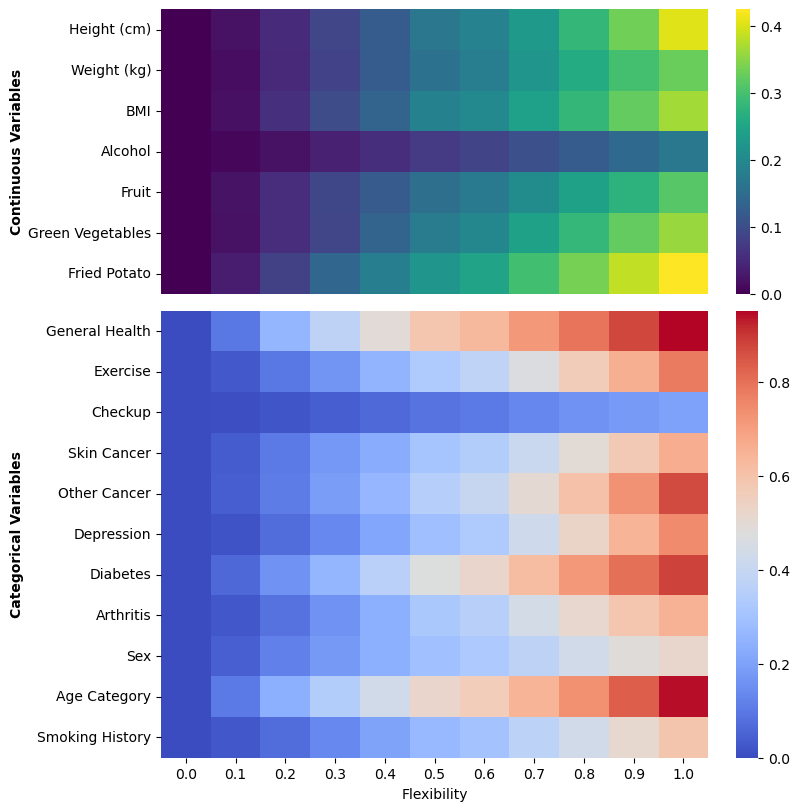

In [5]:
# Define the categorical and continuous columns
cat_cols = {'General_Health': 'General Health', 
            'Exercise': 'Exercise', 
            'Checkup': 'Checkup', 
            'Skin_Cancer': 'Skin Cancer', 
            'Other_Cancer': 'Other Cancer',
            'Depression': 'Depression', 
            'Diabetes': 'Diabetes', 
            'Arthritis': 'Arthritis', 
            'Sex': 'Sex', 
            'Age_Category': 'Age Category', 
            'Smoking_History': 'Smoking History'
            }

cont_cols = {
       'Height_(cm)': "Height (cm)", 
       'Weight_(kg)': 'Weight (kg)', 
       'BMI': 'BMI', 
       'Alcohol_Consumption': 'Alcohol', 
       'Fruit_Consumption': 'Fruit',
       'Green_Vegetables_Consumption': 'Green Vegetables', 
       'FriedPotato_Consumption': "Fried Potato"
       }

# Extract the data for the heatmaps
cont = heart_disease_flexibilities['reconst=0_cf_div=0_clas'][list(cont_cols)].iloc[0:11, :].T
cat = heart_disease_flexibilities['reconst=0_cf_div=0_clas'][list(cat_cols)].iloc[0:11, :].T

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), layout="constrained", height_ratios=[len(cont), len(cat)])
# fig.suptitle("Feature Divergence in Counterfactual Generation")

# Plot the continuous variables heatmap
num_ticks = 5
ticks = np.linspace(cont.to_numpy().min().round(1), cont.to_numpy().max().round(1), num_ticks)
sns.heatmap(cont, ax=ax1, xticklabels=cont.columns.round(1), yticklabels=list(cont_cols.values()), cmap='viridis', cbar_kws={'ticks': ticks})
ax1.set_xticks([])
ax1.set_ylabel('Continuous Variables', fontweight='bold')

# Plot the categorical variables heatmap
ticks = np.linspace(cat.to_numpy().min().round(1), cat.to_numpy().max().round(1), num_ticks)
sns.heatmap(cat, ax=ax2, xticklabels=cat.columns.round(1), yticklabels=list(cat_cols.values()), cmap='coolwarm')
ax2.set_ylabel('Categorical Variables', fontweight='bold')

# Adjust y-axis label alignment
ax1.yaxis.set_label_coords(-0.25, 0.5)
ax2.yaxis.set_label_coords(-0.25, 0.5)

ax2.set_xlabel('Flexibility')

plt.savefig("figures/feature_divergence.png", dpi=100, bbox_inches='tight')

### Counterfactual Distributions

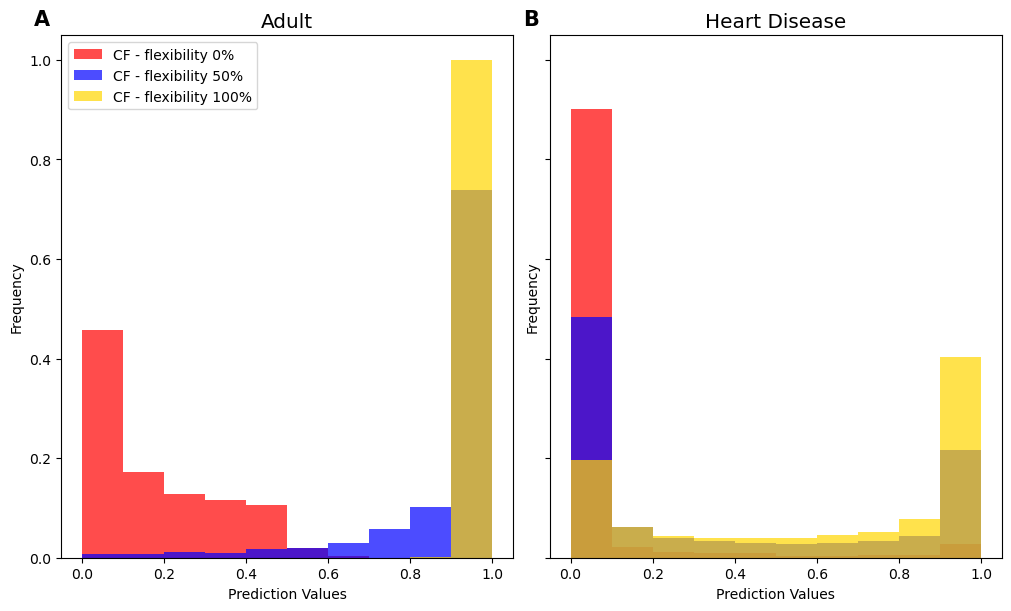

In [6]:
experiments = {
    "CF - flexibility 0%": 0,
    # "CF - flexibility 10%": 0.1,
    "CF - flexibility 50%": 0.5,
    "CF - flexibility 100%": 1,
}

colors = [
    'red', 'blue', 'gold', 'purple', 'green', 
    'black', 'brown', 'pink', 'gray', 'cyan', 
    'magenta', 'yellow'
]

letters = ['A', 'B', 'C', 'D', 'F', 'G']

fig = plt.figure(figsize=(10, 6), layout="constrained")
# fig.suptitle('Distributions of Counterfactual Predictions with Different Flexibilities', fontsize='x-large')
axs = fig.subplot_mosaic([list(results.keys())], sharey=True)

for i, (dataset, prediction_distributions) in enumerate(results.items()):
    combined = pd.concat([preds for preds in prediction_distributions], axis=0)
    bin_edges = np.histogram_bin_edges(combined, bins=10)
    for predictions, label, color in zip(prediction_distributions, experiments.keys(), colors):
        axs[dataset].hist(predictions, bin_edges,
                alpha=0.7, label=label, 
                weights=[1/len(predictions)]*len(predictions),
                color=color)
        
    axs[dataset].set_ylabel('Frequency')  
    axs[dataset].set_title(dataset, fontsize='x-large')
    axs[dataset].set_xlabel('Prediction Values')

    # Adding letters to the panels
    axs[dataset].text(-0.025, 1.05, letters[i], transform=axs[dataset].transAxes, 
                      fontsize=15, fontweight='bold', va='top', ha='right')

    if i == 0:
        axs[dataset].legend(loc='upper left')


plt.savefig("figures/counterfactual_distributions.png", dpi=100)

### No CTGAN Data Transformation

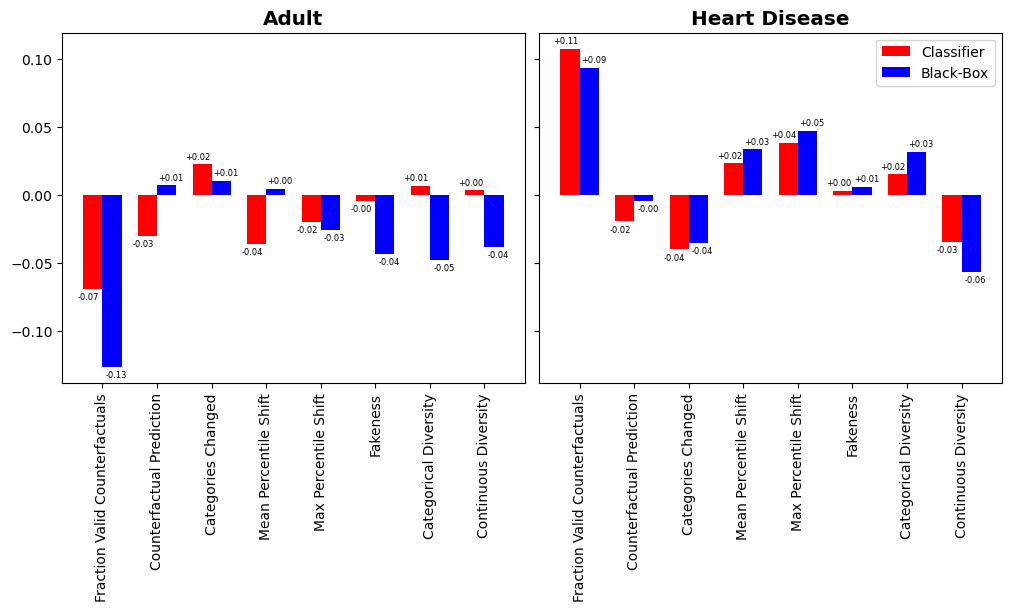

In [7]:
for i in range(1, 6):
    with open(f"experiments2/results/flexibilities{i}.pkl", "rb") as file:
        flexibilities = pickle.load(file)
        for dataset, dataset_label in dataset_names.items():
            combined_flexibilities[dataset_label].append(flexibilities["simple"][dataset])

# Combine the flexibilities for each dataset
plot_flexibilities = {dataset: {key: [item[key] for item in combined_flexibilities[dataset]] for key in combined_flexibilities[dataset][1]} for dataset in combined_flexibilities}



datasets = {
    "Adult": {
        "Classifier": adult_flexibilities["reconst=0_cf_div=0_clas"],
        "Black-Box": adult_flexibilities["reconst=0_cf_div=0_black_box"],
        "No CTGAN Classifier": adult_flexibilities["no_ctgan_clas"],
        "No CTGAN Black-Box": adult_flexibilities["no_ctgan_black_box"],
    },
    "Heart Disease": {
        "Classifier": heart_disease_flexibilities["reconst=0_cf_div=0_clas"],
        "Black-Box": heart_disease_flexibilities["reconst=0_cf_div=0_black_box"],
        "No CTGAN Classifier": heart_disease_flexibilities["no_ctgan_clas"],
        "No CTGAN Black-Box": heart_disease_flexibilities["no_ctgan_black_box"],
    }
}

metric_names = {
    "valid_fraction": "Fraction Valid Counterfactuals",
    "counterfactual_prediction": "Counterfactual Prediction",
    "cat_changed": "Categories Changed", 
    "mean_percentile_shift": "Mean Percentile Shift", 
    "max_percentile_shift": "Max Percentile Shift", 
    "fakeness": "Fakeness", 
    "categorical_diversity": "Categorical Diversity", 
    "continuous_diversity": "Continuous Diversity", 
}


fig = plt.figure(figsize=(10, 6), layout="constrained")
# fig.suptitle('Performance Difference without CTGAN Transformation', fontsize='x-large')
axs = fig.subplot_mosaic([list(datasets.keys())], sharey=True)

bar_width = 0.35
for dataset, models in datasets.items():
    best_results = {}

    for model_name, flexs in models.items():
        best_results[model_name] = flexs.loc[0.5]

    best_results = pd.DataFrame(best_results).loc[list(metric_names.keys()), :]

    classifier_comparison = best_results["No CTGAN Classifier"] - best_results["Classifier"]
    black_box_comparison = best_results["No CTGAN Black-Box"] - best_results["Black-Box"]

    # Create positions for the bars
    bar_positions = pd.Series(range(len(classifier_comparison)))
    bar_positions_shifted = bar_positions + bar_width

    # Plotting the comparisons
    classifier_bars = axs[dataset].bar(bar_positions, classifier_comparison, width=bar_width, label='Classifier', color='red')
    black_box_bars = axs[dataset].bar(bar_positions_shifted, black_box_comparison, width=bar_width, label='Black-Box', color='blue')


    # Labeling the bars
    for bar in classifier_bars:
        height = bar.get_height()
        axs[dataset].text(
            bar.get_x() + bar.get_width() / 2 - 0.08, 
            height + 0.0025 if height > 0 else height - 0.0025, 
            f'+{height:.2f}' if height > 0 else f'{height:.2f}',
            ha='center', 
            va='bottom' if height > 0 else 'top',
            fontsize=6
        )

    for bar in black_box_bars:
        height = bar.get_height()
        axs[dataset].text(
            bar.get_x() + bar.get_width() / 2 + 0.08, 
            height + 0.0025 if height > 0 else height - 0.0025, 
            f'+{height:.2f}' if height > 0 else f'{height:.2f}',
            ha='center', 
            va='bottom' if height > 0 else 'top',
            fontsize=6
        )

    # Set the tick positions and labels
    axs[dataset].set_xticks(bar_positions + bar_width / 2)
    axs[dataset].set_xticklabels(list(metric_names.values()), rotation=90)

    axs[dataset].set_title(dataset, fontsize='x-large', fontweight='bold')

    if dataset == "Heart Disease":
        axs[dataset].legend()

plt.savefig("figures/no_ctgan.png", dpi=100)

### CFGAN divergence fine tuning

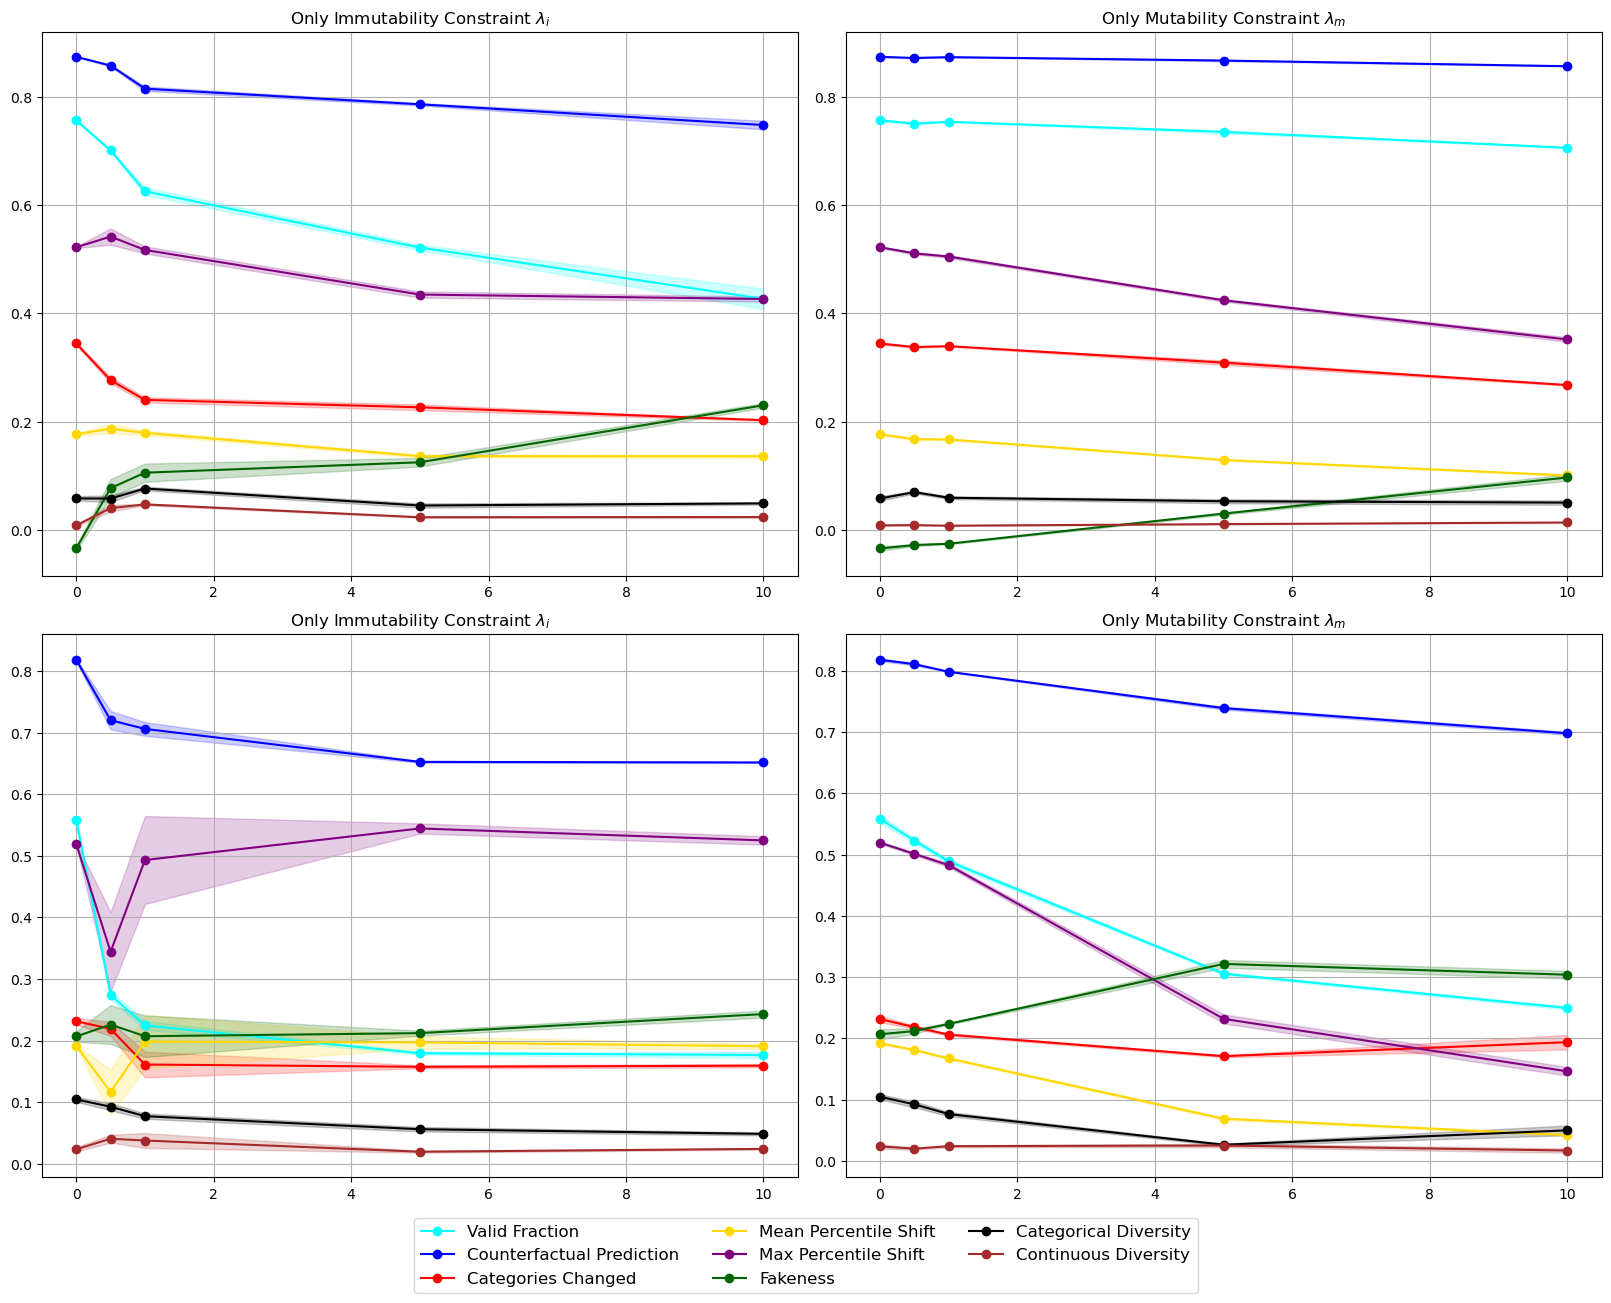

In [14]:
from sklearn.metrics import auc
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

### DIVERGENCE INFLUENCE ###
metric_names = {
    "valid_fraction": {"label": "Valid Fraction", "color": "cyan"},
    "counterfactual_prediction": {"label": "Counterfactual Prediction", "color": "blue"},
    "cat_changed": {"label": "Categories Changed", "color": "red"}, 
    "mean_percentile_shift": {"label": "Mean Percentile Shift", "color": "gold"}, 
    "max_percentile_shift": {"label": "Max Percentile Shift", "color": "purple"}, 
    "fakeness": {"label": "Fakeness", "color": "darkgreen"}, 
    "categorical_diversity": {"label": "Categorical Diversity", "color": "black"}, 
    "continuous_diversity": {"label": "Continuous Diversity", "color": "brown"}, 
}

# Iterate over the five files and load the flexibilities
combined_flexibilities = []
for i in range(1, 6):
    with open(f"experiments2/results/flexibilities{i}.pkl", "rb") as file:
        flexibilities = pickle.load(file)
        combined_flexibilities.append(flexibilities["simple"]["adult"])


experiment_labels = {
    "clas_reconst": {
        0: 'clas_cfgan_no_div',
        0.5: 'clas_cfgan_reconst_div=0.5',
        1: 'clas_cfgan_small_reconst_div',
        5: 'clas_cfgan_reconst_div=5',
        10: 'clas_cfgan_large_reconst_div',
    },
    "clas_cf": {
        0: 'clas_cfgan_no_div',
        0.5: 'clas_cfgan_cf_div=0.5',
        1: 'clas_cfgan_cf_div=1',
        5: 'clas_cfgan_cf_div=5',
        10: 'clas_cfgan_cf_div=10',
    },
    "black_box_reconst": {
        0: 'black_box_cfgan_no_div',
        0.5: 'black_box_cfgan_small_reconst_div',
        1: 'black_box_cfgan_reconst_div=1',
        5: 'black_box_cfgan_large_reconst_div',
        10: 'black_box_cfgan_reconst_div=10',
    },
    "black_box_cf": {
        0: 'black_box_cfgan_no_div',
        0.5: 'black_box_cfgan_cf_div=0.5',
        1: 'black_box_cfgan_cf_div=1',
        5: 'black_box_cfgan_cf_div=5',
        10: 'black_box_cfgan_cf_div=10',
    }
}

# Combine the flexibilities for each dataset
plot_flexibilities = {key: [item[key] for item in combined_flexibilities] for key in combined_flexibilities[1]}

# Combine all experiments for a specific label in the structure of 'experiment_labels'
combined_experiments = {}
for label, experiments_dict in experiment_labels.items():
    combined_experiments[label] = {}
    for div_value, experiment_name in experiments_dict.items():
        combined_experiments[label][div_value] = []
        for flex in combined_flexibilities:
            combined_experiments[label][div_value].append(flex[experiment_name])

# Calculate the area under the curve for each metric
mean_flexibilities = {}
sem_flexibilities = {}
for label, data in combined_experiments.items():
    mean_flexibilities[label] = {}
    sem_flexibilities[label] = {}
    for div_value, values in data.items():
        mean_flexibilities[label][div_value] = {}
        sem_flexibilities[label][div_value] = {}
        for metric in metric_names.keys():
            auc_values = [auc(value[metric].index, value[metric]) for value in values]
            mean = np.mean(auc_values)
            sem = np.std(auc_values, ddof=1) / np.sqrt(len(auc_values))
            mean_flexibilities[label][div_value][metric] = mean
            sem_flexibilities[label][div_value][metric] = sem

    mean_flexibilities[label] = pd.DataFrame(mean_flexibilities[label]).T
    sem_flexibilities[label] = pd.DataFrame(sem_flexibilities[label]).T

experiments = {
    "A": {
        "title": "Classifier",
        "name": r'Only Immutability Constraint $\lambda_i$',
        "data_name": "clas_reconst",
        "div_type": "reconst_div_infl"
        },
    "B": {
        "title": "Classifier",
        "name": r'Only Mutability Constraint $\lambda_m$',
        "data_name": "clas_cf",
        "div_type": "cf_div_infl"
        },
    "C": {
        "title": "Black-Box",
        "name": r'Only Immutability Constraint $\lambda_i$',
        "data_name": "black_box_reconst",
        "div_type": "reconst_div_infl"
        },
    "D": {
        "title": "Black-Box",
        "name": r'Only Mutability Constraint $\lambda_m$',
        "data_name": "black_box_cf",
        "div_type": "cf_div_infl"
        },
}

fig_letters = [["A", "B"], ["C", "D"]]

fig, axs = plt.subplots(2, 2, figsize=(16, 12), constrained_layout=True)
# fig.suptitle("Influence of Divergence Constraints CFGAN (Adult)", fontsize='xx-large')

for i, subfig_letters in enumerate(fig_letters):
    for j, c in enumerate(subfig_letters):
        data_name = experiments[c]["data_name"]
        name = experiments[c]["name"]
        div_type = experiments[c]["div_type"]
        
        for metric, config in metric_names.items():
            axs[i, j].plot(
                mean_flexibilities[data_name].index,
                mean_flexibilities[data_name][metric], 
                label=config["label"], 
                color=config["color"],
                marker='o'
            )
            axs[i, j].fill_between(
                mean_flexibilities[data_name].index,
                mean_flexibilities[data_name][metric] - sem_flexibilities[data_name][metric],
                mean_flexibilities[data_name][metric] + sem_flexibilities[data_name][metric],
                color=config["color"],
                alpha=0.2
            )
        axs[i, j].set_title(name)
        axs[i, j].grid()
        # axs[i, j].legend()

# Create a single legend for the entire figure
lines, labels = [], []
for _, config in metric_names.items():
    line = plt.Line2D([0], [0], color=config["color"], marker='o')
    lines.append(line)
    labels.append(config["label"])

fig.legend(lines, labels, loc='lower center', bbox_to_anchor=[0.5, -0.08], ncol=3, fontsize='large')

plt.savefig("figures/finetune_div_cfgan.png", dpi=100, bbox_inches='tight')

### Confusion matrices classifiers

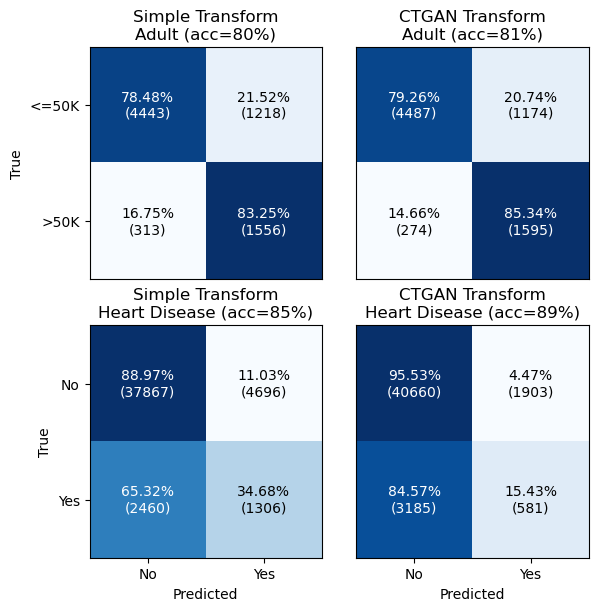

In [10]:
label_names = {
    "adult": {
        "dataset": "Adult",
        "targets": ["<=50K", ">50K"]
    },
    "heart_disease": {
        "dataset": "Heart Disease",
        "targets": ["No", "Yes"]
    }
}

classifier_types = ["Simple", "CTGAN"]
# mosaic = [classifier_types]
mosaic = [
    ["Simple_Adult", "CTGAN_Adult"],
    ["Simple_Heart Disease", "CTGAN_Heart Disease"] 
]

# Create a 2x2 grid of heatmaps
fig = plt.figure(layout='constrained', figsize=(6, 6))
# fig.suptitle("Confusion Matrices for Classifiers", fontsize='x-large')

# subfigs = fig.subfigures(2, 1, hspace=0.07)
# axs = fig.subplot_mosaic([classifier_types])
axs = fig.subplot_mosaic(mosaic)

# Function to determine the color of the text
def get_text_color(value, threshold=50):
    """Returns white or black based on the threshold."""
    return 'white' if value > threshold else 'black'


for i, dataset in enumerate(label_names):
    dataset_name = label_names[dataset]["dataset"]
    # axs = subfigs[i].subplot_mosaic([classifier_types])

    for classifier_type in classifier_types:
        # ax = axs[classifier_type]
        ax = axs[classifier_type + "_" + dataset_name]
        cm_instance = confusion_matrices[classifier_type+dataset]
        cax = ax.matshow(cm_instance["percentage"], cmap='Blues')

        # Create annotations with both percentages and absolute values
        labels = [f'{perc:.2f}%\n({val})' for perc, val in zip(cm_instance["percentage"].flatten(), cm_instance["absolute"].flatten())]
        labels = np.asarray(labels).reshape(2, 2)

        # Annotate the heatmap
        for (i, j), val in np.ndenumerate(cm_instance["percentage"]):
            ax.text(j, i, labels[i, j], ha='center', va='center', 
                    color=get_text_color(cm_instance["percentage"][i, j]))

        # Set axis labels
        if cm_instance["type"] == "Simple":
            ax.set_yticks(np.arange(2))
            ax.set_yticklabels(label_names[cm_instance["dataset"]]["targets"])
            ax.set_ylabel('True')
        else:
            ax.set_yticks([])

        if cm_instance["dataset"] == "heart_disease":
            ax.set_xticks(np.arange(2))
            ax.set_xticklabels(label_names[cm_instance["dataset"]]["targets"])
            ax.xaxis.set_ticks_position('bottom')
            ax.set_xlabel('Predicted')
        else:
            ax.set_xticks([])

        ax.set_title(f'{cm_instance["type"]} Transform\n{label_names[cm_instance["dataset"]]["dataset"]} (acc={round(cm_instance["accuracy"]*100)}%)')

plt.savefig("figures/classifier_confusion_matrices.png", dpi=100)
plt.show()

### Optimization finetuning

Adult
Heart Disease


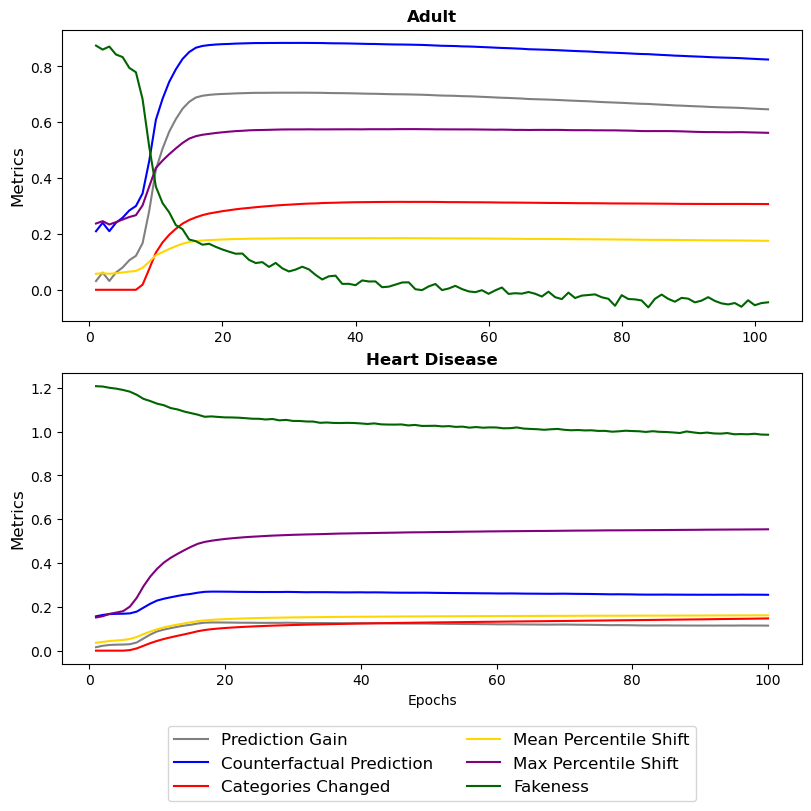

In [11]:
with open("results2plot/optimization_tune/adult_optim_metrics.json", "r") as file:
        adult_optim_metrics = json.load(file)["Quality measures"]

with open("results2plot/optimization_tune/heart_disease_optim_metrics.json", "r") as file:
        heart_disease_optim_metrics = json.load(file)["Quality measures"]

optim_metrics = {
    "Adult": adult_optim_metrics,
    "Heart Disease": heart_disease_optim_metrics
}

metric_names = {
    "prediction_gain": {"label": "Prediction Gain", "color": "grey"},
    "counterfactual_pred": {"label": "Counterfactual Prediction", "color": "blue"},
    "cat_changed": {"label": "Categories Changed", "color": "red"}, 
    "mean_percentile_shift": {"label": "Mean Percentile Shift", "color": "gold"}, 
    "max_percentile_shift": {"label": "Max Percentile Shift", "color": "purple"}, 
    "fakeness": {"label": "Fakeness", "color": "darkgreen"}, 
}

colors = [
    'red', 'blue', 'gold', 'purple', 'green', 
    'black', 'brown', 'pink', 'gray', 'cyan', 
    'magenta', 'yellow'
]


# Determine the number of subplots needed
fig = plt.figure(figsize=(8, 8), layout='constrained')
# fig.suptitle("Optimization Performance with Growing Gradient Steps", fontsize="xx-large")
axs = fig.subplot_mosaic([[dataset] for dataset in optim_metrics.keys()])

# Iterate through each subplot data
for dataset, metrics in optim_metrics.items():
    epochs = range(1, len(metrics[list(metrics)[0]]) + 1)

    print(dataset)
    for metric, config in metric_names.items():
        axs[dataset].plot(epochs, metrics[metric], label=config["label"], color=config["color"])
    axs[dataset].set_ylabel("Metrics", fontsize='large')
    axs[dataset].set_title(dataset, fontweight='bold', fontsize='large')

    if dataset == "Heart Disease":
        axs[dataset].set_xlabel("Epochs")
        axs[dataset].legend(loc='lower center', bbox_to_anchor=[0.5, -0.5], ncol=2, fontsize='large', labels=[config["label"] for config in metric_names.values()])


plt.savefig("figures/optimization_fine_tune.png", dpi=100)
plt.show()